# YOLO, YOLO PX, YOLO PX II method analysis and final errors for DS-IE
- Code to train YOLO model to predict images 0 - 400

In [ ]:
NOTEBOOK_CONFIG = {'label_mode': True,
                   'train_mode': True,
                   'IMG_LENGTH': 0.377,
                   'IMG_WIDTH': 0.143,
                   'IMG_XDIM': 143,
                   'IMG_YDIM': 377,
                   'labels_type' : "Labelsv0_detect",
                   'task' : "detect",
                   'model_name' : "YOLOv0_E12_detect"
                   }

In [2]:
# Folders
# Location of images
images_folder = f"../docs/Data/Images/"
# Locations of yolo's datasets
yolo_folder = f"../docs/Models/{NOTEBOOK_CONFIG['yolo_type']}/datasets/"
# Location of labels
labels_folder= f"../docs/Data/{NOTEBOOK_CONFIG['labels_type']}/"
# Location of trained models
model_folder = f"../docs/Models/{NOTEBOOK_CONFIG['yolo_type']}/"

In [3]:
# Path for sample image
n_image = 203
image_path = f"../docs/Data/Images/gaussian_{n_image}.png"
label_path = f"../docs/Data/{NOTEBOOK_CONFIG['labels_type']}/gaussian_{n_image}.txt"

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
import os
import pandas as pd
import numpy as np

from datetime import datetime
import scipy.io

from matplotlib import pyplot as plt
from adjustText import adjust_text

In [6]:
from ultralytics import YOLO
import cv2
from PIL import Image

# Load modules

In [13]:
# Training runs (best)
bst_run = {'YOLOv0_detect' : '2023-07-26_18-50-24',
           'YOLOv0_E2_detect' : '2023-08-21_09-27-11',
           'YOLOv0_E3_detect' : '2023-08-21_10-25-30',
           'YOLOv0_E4_detect' : '2023-08-21_14-37-58',
           "YOLOv0_E12_detect" : "2023-08-21_13-57-46",
           'YOLOv0_T80kenji_detect' : '2023-09-04_11-19-43'}

In [ ]:
# Load custom model
base_path = "../docs/Models"
model_path = (f"{NOTEBOOK_CONFIG['model_name']}/runs/
              {bst_run[NOTEBOOK_CONFIG['model_name']]}/
              {NOTEBOOK_CONFIG['task']}")

model = YOLO(f"{base_path}/{model_path}/train/weights/best.pt")

In [ ]:
import sys
sys.path.append("..")

In [ ]:
from helpers.gaussian_generator import generate_grid
from helpers.auxiliary_functions import (parameters_extract,
                                         checkpoint_error)
from helpers.aux_plotter import (plot_boxes,
                                 plot_boxes_gmm,
                                 gaussians_labelled,
                                 plot_grayscale,
                                 plot_box_labels)
from pipelines.pipelines import (ppl_fit_gaussians,
                                 ppl_error_estimation,
                                 ppl_yolo_predict_gaussians,
                                 ppl_yolo_px_predict_gaussians,
                                 ppl_ensemble_predict_gaussians)
from helpers.error_estimation import compute_error_per_gaussian

# Data from CNR

## Load
- Real size of the tile is roughly equal to 2 pixel / mm

In [15]:
# Load 400 gaussians
mat = scipy.io.loadmat('../docs/Data/db_80beam.mat')
print(mat.keys())

dict_keys(['__header__', '__version__', '__globals__', 'F_data', 'Fit_flux', 'beta'])


In [16]:
# Generate GRID
x, y = generate_grid((0, NOTEBOOK_CONFIG['IMG_WIDTH']), 
                     (0, NOTEBOOK_CONFIG['IMG_LENGTH']), 
                     NOTEBOOK_CONFIG['IMG_XDIM'], 
                     NOTEBOOK_CONFIG['IMG_YDIM'])

# [ESTIMATION PART I and II]
- Images: 0 - 200
  - All amplitudes are higher around 1.5E6 (250%)
  - x center coincides with beta xs
  - y center It has some Gaussians deslocated to up and other to down around 0.01 in y direction
  - dispersion in x Higher dispersion in x directions around 0.003 (40%)
  - dispersion in y Higher dispersion in y direction around 0.002 (40%)

- PLUS: Images: 200 - 400
  - Amplitudes: All amplitudes are higher around 2E6 (350%)
  - x center: It has some Gaussians deslocated to left and others to right around 0.004 in x direction
  - y center: Coincides with beta ys
  - dispersion x : Higher dispersion in x direction around 0.006 (60%)
  - dispersion y : Higher dispersion in y direction around 0.003 (60%)

## [ESTIMATION] Pipeline ppl_Yolo

### Yolo structure - distribute images in folder

### Predict with custom model - YOLOv0

In [24]:
os.listdir("../docs/Models")

['YOLOv0_detect',
 'YOLOv0_E2_detect',
 'YOLOv0_E3_detect',
 'YOLOv0_E12_detect',
 'YOLOv0_E4_detect',
 'Archive',
 'YOLOv0_E1_detect',
 'YOLOv0_T80kenji_detect']

In [25]:
os.listdir("../docs/Models/YOLOv0_detect/datasets/test/images/")

['gaussian_738.png',
 'gaussian_777.png',
 'gaussian_650.png',
 'gaussian_772.png',
 'gaussian_703.png',
 'gaussian_704.png',
 'gaussian_726.png',
 'gaussian_710.png',
 'gaussian_601.png',
 'gaussian_622.png',
 'gaussian_664.png',
 'gaussian_694.png',
 'gaussian_690.png',
 'gaussian_700.png',
 'gaussian_605.png',
 'gaussian_719.png',
 'gaussian_614.png',
 'gaussian_603.png',
 'gaussian_766.png',
 'gaussian_714.png']

In [34]:
# Wrap sizes and ranges
image_ranges = [(0, NOTEBOOK_CONFIG['IMG_WIDTH']), 
                (0, NOTEBOOK_CONFIG['IMG_LENGTH'])]
image_size = [NOTEBOOK_CONFIG['IMG_XDIM'], 
              NOTEBOOK_CONFIG['IMG_YDIM']]

In [35]:
# Make the prediction
img = cv2.imread(image_path)
results = model.predict(img)

# class 0 boxes
tensor_boxes = results[0].boxes.xyxy

# Centers
means_yolo = [(float(x),
          float(y)) for
          x,y in zip(results[0].boxes.xywhn[:, 0] * image_size[0],
                     results[0].boxes.xywhn[:, 1]  * image_size[1])]


0: 640x256 79 gaussians, 506.2ms
Speed: 2.0ms preprocess, 506.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 256)


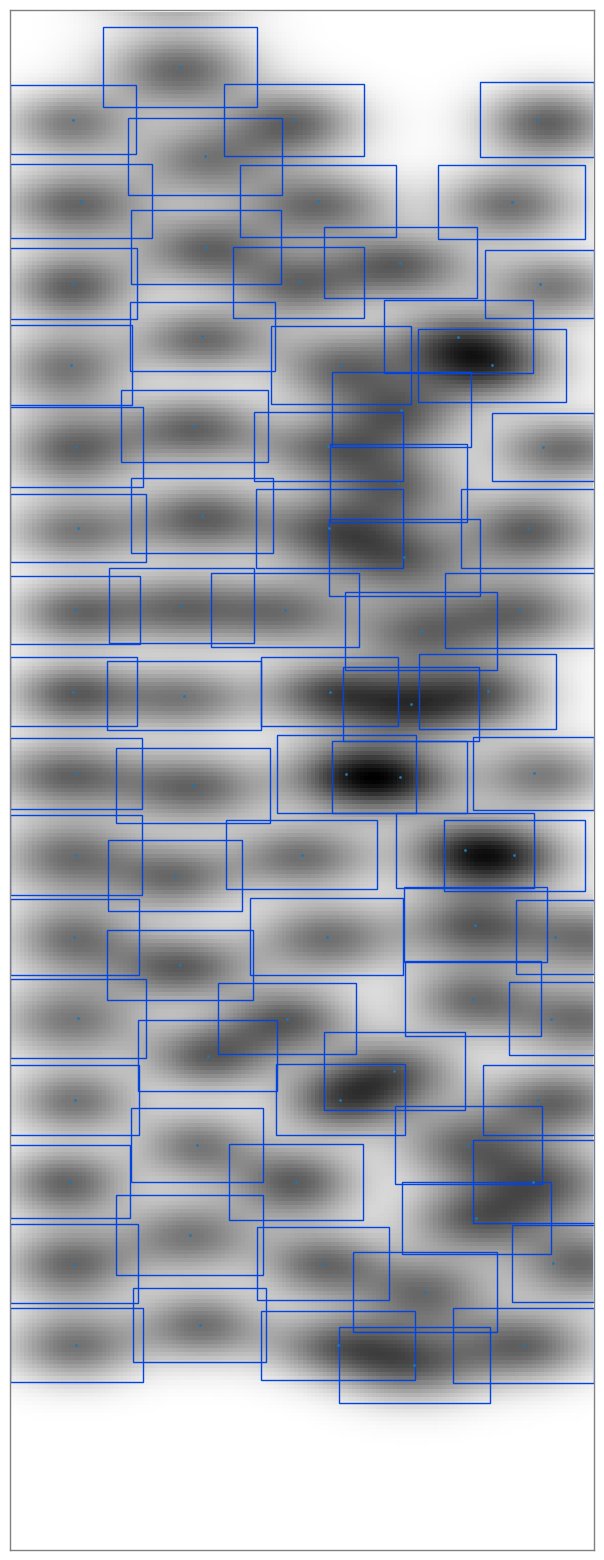

In [36]:
# Open the image file
im = Image.open(image_path)

# Create figure and axes
fig, ax = plt.subplots(1, figsize = (15, 20))

# Display the image and plot predicted centers
ax.imshow(im)
plot_boxes(tensor_boxes,
           ax,
           edge_color = 'g')
ax.set_ylim(ax.get_ylim()[::-1])
ax.scatter(np.array(means_yolo )[:,0], 
           np.array(means_yolo)[:, 1], s = 1)
# axs[2].axis('off')
ax.set_xlim(0, NOTEBOOK_CONFIG['IMG_XDIM'])
ax.set_ylim(0, NOTEBOOK_CONFIG['IMG_YDIM'])

ax.xaxis.label.set_text("")
ax.yaxis.label.set_text("")

ax.set_xticks([])
ax.set_yticks([])
# Change the color of the axis spines (borders)
for spine in ax.spines.values():
    spine.set_edgecolor('gray')
    spine.set_linewidth(1)

plt.show()

In [ ]:
# Estimate Gaussian - Final prediction
image = [x, y, mat['F_data'][:,:, n_image]]
(means,
 covariances,
 angles,
 amplitudes) = ppl_fit_gaussians(image,
                                 means_init = 'laplace',
                                 peak_method = 'laplace',
                                 em_iterations = 1000,
                                 covariance_gaussians_type = 'diag',
                                 n_gaussians = None,
                                 image_ranges = image_ranges,
                                 image_size = image_size,
                                 fig_size = (10, 8),
                                 plot = True,
                                 plot_points = True)

Number of indentifiable Gaussians (center in the image): 79


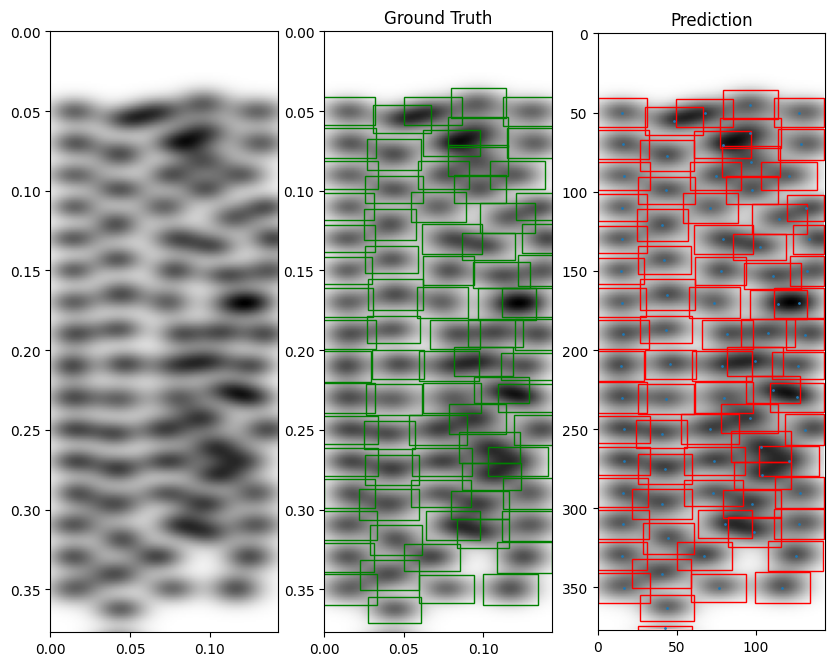

In [ ]:
# Open the image file
im = Image.open(image_path)

# Create figure and axes
fig, axs = plt.subplots(1, 4, figsize = (15, 20))

# Display the image and plot predicted centers GMM
axs[2].imshow(im)
plot_boxes_gmm(means = means,
               covariances = covariances,
               ax = axs[2],
               beta = 3,
               edge_color = '#0343DF')
axs[2].set_ylim(ax.get_ylim()[::-1])
axs[2].scatter(means[:,0] * 1000, 
               means[:, 1] * 1000, 
               s = 1)
# axs[3].axis('off')
axs[2].set_xlim(0, NOTEBOOK_CONFIG['IMG_XDIM'])
axs[2].set_ylim(0, NOTEBOOK_CONFIG['IMG_YDIM'])


# Display the image and plot predicted centers
axs[3].imshow(im)
plot_boxes(tensor_boxes,
           axs[3],
           edge_color = 'g')
axs[3].set_ylim(axs[2].get_ylim()[::-1])
axs[3].scatter(np.array(means_yolo )[:,0], 
               np.array(means_yolo)[:, 1], 
               s = 1)
# axs[2].axis('off')
axs[3].set_xlim(0, NOTEBOOK_CONFIG['IMG_XDIM'])
axs[3].set_ylim(0, NOTEBOOK_CONFIG['IMG_YDIM'])

#axs[2].set_title("Prediction")

# Labelling
x, y, z = gaussians_labelled(image_path,
                   label_path,
                   axs[1],
                   task = NOTEBOOK_CONFIG['task'],
                   colorbar = False,
                   plot_centers = True)
# axs[1].axis('off')
axs[1].set_xlim(0, NOTEBOOK_CONFIG['IMG_WIDTH'])
axs[1].set_ylim(0, NOTEBOOK_CONFIG['IMG_LENGTH'])
#axs[1].set_title("Ground Truth")

# Image
plot_grayscale(x, y, z, colorbar = False, ax = axs[0])
# axs[0].axis('off')
axs[0].set_xlim(0, NOTEBOOK_CONFIG['IMG_WIDTH'])
axs[0].set_ylim(0, NOTEBOOK_CONFIG['IMG_LENGTH'])


for ax in axs:
  ax.xaxis.label.set_text("")
  ax.yaxis.label.set_text("")

  ax.set_xticks([])
  ax.set_yticks([])
  # Change the color of the axis spines (borders)
  for spine in ax.spines.values():
      spine.set_edgecolor('gray')
      spine.set_linewidth(1)

plt.subplots_adjust(wspace= 0.08)
plt.show()

### Error evaluation

In [ ]:
# Get number of images that need to be evaluated - YOLO test set
images_test = os.listdir(f"../docs/Models/{NOTEBOOK_CONFIG['model_name']}/datasets/test/images/")
eval_images = [int(i.split('_')[1].split('.')[0]) for i in images_test] # Use the same images of the test from YOLO

In [ ]:
# Iterate all images - GMM method
results = {'Image' : [],
           'Number identified - YOLO' : [],
           'Number identifiable - YOLO' : [],
           'Percentage - YOLO' : [],
           'RMSE_cx - YOLO' : [],
           'RMSE_cy - YOLO' : [],
           'RMSE_c - YOLO' : [],
           'RMSE_sigmax - YOLO' : [],
           'RMSE_sigmay - YOLO' : [],
           'RMSE_sigma - YOLO' : [],
           'MaxE_sigmax - YOLO': [],
           'MaxE_sigmay - YOLO': [],
           'MaxE_sigma - YOLO': [],
           'RMSE_amplitude - YOLO': [],
           'RMSEPixel - YOLO': []}

for n_image in eval_images:
  eval_gaussian = ppl_error_estimation(n_image,
                                       mat,
                                       estimation_method = "YOLO",
                                       image_path = "../Data/Images/",
                                       yolo_model = model,
                                       covariance_gaussians_types = "diag",
                                       return_percentage = True)
  # Append values in the dictionary
  for key in results.keys():
      if key in eval_gaussian:
          results[key] += eval_gaussian[key]


0: 640x256 77 gaussians, 1024.6ms
Speed: 22.0ms preprocess, 1024.6ms inference, 33.8ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[    0.01152           0]
  [          0   0.0076559]]]
covariances true [[[   0.011456           0]
  [          0   0.0076081]]]



0: 640x256 77 gaussians, 516.7ms
Speed: 1.8ms preprocess, 516.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.013246           0]
  [          0   0.0068977]]]
covariances true [[[   0.013029           0]
  [          0   0.0069073]]]



0: 640x256 76 gaussians, 456.6ms
Speed: 2.0ms preprocess, 456.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.014082           0]
  [          0    0.005895]]]
covariances true [[[   0.014005           0]
  [          0    0.005867]]]



0: 640x256 76 gaussians, 1130.1ms
Speed: 1.9ms preprocess, 1130.1ms inference, 10.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.013251           0]
  [          0   0.0067876]]]
covariances true [[[   0.013057           0]
  [          0   0.0069026]]]



0: 640x256 78 gaussians, 415.3ms
Speed: 1.6ms preprocess, 415.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.012262           0]
  [          0   0.0063411]]]
covariances true [[[   0.012098           0]
  [          0   0.0062757]]]



0: 640x256 76 gaussians, 488.4ms
Speed: 2.0ms preprocess, 488.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.014357           0]
  [          0   0.0073565]]]
covariances true [[[   0.014293           0]
  [          0   0.0073547]]]



0: 640x256 77 gaussians, 798.6ms
Speed: 2.8ms preprocess, 798.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.014419           0]
  [          0   0.0072034]]]
covariances true [[[   0.014285           0]
  [          0   0.0072075]]]



0: 640x256 77 gaussians, 505.2ms
Speed: 2.0ms preprocess, 505.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.012577           0]
  [          0   0.0071186]]]
covariances true [[[   0.012539           0]
  [          0       0.007]]]



0: 640x256 73 gaussians, 476.6ms
Speed: 1.9ms preprocess, 476.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.014498           0]
  [          0   0.0066782]]]
covariances true [[[   0.014311           0]
  [          0   0.0066495]]]



0: 640x256 78 gaussians, 304.1ms
Speed: 2.4ms preprocess, 304.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[    0.01208           0]
  [          0   0.0077728]]]
covariances true [[[   0.012032           0]
  [          0   0.0077143]]]



0: 640x256 77 gaussians, 443.4ms
Speed: 2.0ms preprocess, 443.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.014071           0]
  [          0   0.0072587]]]
covariances true [[[    0.01402           0]
  [          0   0.0072125]]]



0: 640x256 78 gaussians, 419.4ms
Speed: 2.0ms preprocess, 419.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.011617           0]
  [          0   0.0062129]]]
covariances true [[[   0.011448           0]
  [          0   0.0061521]]]



0: 640x256 78 gaussians, 255.3ms
Speed: 1.5ms preprocess, 255.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.012757           0]
  [          0   0.0070232]]]
covariances true [[[   0.012663           0]
  [          0   0.0070102]]]



0: 640x256 77 gaussians, 262.2ms
Speed: 2.4ms preprocess, 262.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.012485           0]
  [          0   0.0072914]]]
covariances true [[[   0.012455           0]
  [          0   0.0073381]]]



0: 640x256 76 gaussians, 249.3ms
Speed: 1.8ms preprocess, 249.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.013652           0]
  [          0   0.0073498]]]
covariances true [[[    0.01359           0]
  [          0   0.0073286]]]



0: 640x256 74 gaussians, 260.2ms
Speed: 2.0ms preprocess, 260.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.013539           0]
  [          0   0.0068485]]]
covariances true [[[   0.013444           0]
  [          0   0.0068116]]]



0: 640x256 75 gaussians, 264.9ms
Speed: 2.5ms preprocess, 264.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.011324           0]
  [          0   0.0071303]]]
covariances true [[[    0.01123           0]
  [          0   0.0070273]]]



0: 640x256 77 gaussians, 267.8ms
Speed: 1.6ms preprocess, 267.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.013536           0]
  [          0   0.0064495]]]
covariances true [[[   0.013454           0]
  [          0   0.0064014]]]



0: 640x256 77 gaussians, 257.9ms
Speed: 1.9ms preprocess, 257.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.013752           0]
  [          0   0.0075211]]]
covariances true [[[   0.014392           0]
  [          0   0.0073371]]]



0: 640x256 76 gaussians, 246.0ms
Speed: 2.1ms preprocess, 246.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.012209           0]
  [          0   0.0064438]]]
covariances true [[[    0.01212           0]
  [          0   0.0063972]]]



0: 640x256 79 gaussians, 430.0ms
Speed: 2.0ms preprocess, 430.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.017047           0]
  [          0     0.00863]]]
covariances true [[[   0.017368           0]
  [          0   0.0086248]]]



0: 640x256 80 gaussians, 412.7ms
Speed: 2.0ms preprocess, 412.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.015922           0]
  [          0   0.0088045]]]
covariances true [[[   0.016009           0]
  [          0   0.0087787]]]



0: 640x256 80 gaussians, 267.2ms
Speed: 2.9ms preprocess, 267.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.017749           0]
  [          0   0.0088854]]]
covariances true [[[   0.017855           0]
  [          0   0.0089247]]]



0: 640x256 79 gaussians, 263.5ms
Speed: 2.1ms preprocess, 263.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.016311           0]
  [          0   0.0079236]]]
covariances true [[[   0.016302           0]
  [          0   0.0079472]]]



0: 640x256 80 gaussians, 266.6ms
Speed: 2.3ms preprocess, 266.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.015779           0]
  [          0   0.0087974]]]
covariances true [[[   0.015694           0]
  [          0   0.0087361]]]



0: 640x256 79 gaussians, 261.4ms
Speed: 4.0ms preprocess, 261.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.015254           0]
  [          0   0.0093527]]]
covariances true [[[   0.015138           0]
  [          0   0.0093174]]]



0: 640x256 80 gaussians, 253.6ms
Speed: 1.5ms preprocess, 253.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.016462           0]
  [          0   0.0091977]]]
covariances true [[[   0.016268           0]
  [          0   0.0091864]]]



0: 640x256 79 gaussians, 256.9ms
Speed: 1.9ms preprocess, 256.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.016274           0]
  [          0   0.0088483]]]
covariances true [[[    0.01625           0]
  [          0   0.0088413]]]



0: 640x256 79 gaussians, 266.8ms
Speed: 2.1ms preprocess, 266.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.016577           0]
  [          0   0.0082585]]]
covariances true [[[   0.016485           0]
  [          0   0.0082784]]]



0: 640x256 80 gaussians, 448.4ms
Speed: 2.0ms preprocess, 448.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.016877           0]
  [          0     0.00824]]]
covariances true [[[   0.016971           0]
  [          0   0.0081787]]]



0: 640x256 79 gaussians, 457.5ms
Speed: 1.9ms preprocess, 457.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[    0.01471           0]
  [          0    0.009004]]]
covariances true [[[   0.016689           0]
  [          0   0.0090616]]]



0: 640x256 79 gaussians, 249.7ms
Speed: 1.9ms preprocess, 249.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.015123           0]
  [          0   0.0088901]]]
covariances true [[[    0.01503           0]
  [          0   0.0088039]]]



0: 640x256 79 gaussians, 263.0ms
Speed: 1.9ms preprocess, 263.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.015693           0]
  [          0   0.0085176]]]
covariances true [[[   0.015653           0]
  [          0   0.0085055]]]



0: 640x256 79 gaussians, 254.8ms
Speed: 2.6ms preprocess, 254.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.015486           0]
  [          0   0.0081205]]]
covariances true [[[   0.015368           0]
  [          0   0.0079957]]]



0: 640x256 79 gaussians, 271.5ms
Speed: 2.0ms preprocess, 271.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.015414           0]
  [          0   0.0086324]]]
covariances true [[[   0.015066           0]
  [          0     0.00857]]]



0: 640x256 79 gaussians, 250.3ms
Speed: 1.9ms preprocess, 250.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.016028           0]
  [          0   0.0088321]]]
covariances true [[[   0.015879           0]
  [          0   0.0087753]]]



0: 640x256 80 gaussians, 260.9ms
Speed: 2.1ms preprocess, 260.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.015783           0]
  [          0   0.0088333]]]
covariances true [[[   0.015896           0]
  [          0   0.0088842]]]



0: 640x256 79 gaussians, 261.1ms
Speed: 4.2ms preprocess, 261.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.015536           0]
  [          0   0.0087228]]]
covariances true [[[   0.015484           0]
  [          0   0.0086454]]]



0: 640x256 81 gaussians, 324.7ms
Speed: 2.7ms preprocess, 324.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.017151           0]
  [          0   0.0086221]]]
covariances true [[[    0.01689           0]
  [          0   0.0086072]]]



0: 640x256 79 gaussians, 454.7ms
Speed: 1.9ms preprocess, 454.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.017853           0]
  [          0   0.0089644]]]
covariances true [[[   0.017898           0]
  [          0    0.009004]]]


In [ ]:
pd.DataFrame.from_dict(results).describe().round(2).loc[['mean', 'std', 'max']].T

,mean,std,max
Image,218.95,124.81,399.00
Number identified - YOLO,77.95,1.78,81.00
Number identifiable - YOLO,79.05,0.55,80.00
Percentage - YOLO,98.61,2.23,102.53
RMSE_cx - YOLO,1.72,0.70,3.61
RMSE_cy - YOLO,0.08,0.04,0.31
RMSE_c - YOLO,1.73,0.70,3.62
RMSE_sigmax - YOLO,3.61,1.94,6.98
RMSE_sigmay - YOLO,1.62,0.67,3.51
RMSE_sigma - YOLO,4.17,1.58,7.01


In [ ]:
# Results
pd.DataFrame.from_dict(results).round(2).sort_values('Image')

,Image,Number identified - YOLO,Number identifiable - YOLO,Percentage - YOLO,RMSE_cx - YOLO,RMSE_cy - YOLO,RMSE_c - YOLO,RMSE_sigmax - YOLO,RMSE_sigmay - YOLO,RMSE_sigma - YOLO,MaxE_sigmax - YOLO,MaxE_sigmay - YOLO,MaxE_sigma - YOLO,RMSE_amplitude - YOLO,RMSEPixel - YOLO
2,6,76,79,96.20,1.01,0.07,1.02,1.67,1.91,2.54,6.73,29.33,30.10,22.50,541902.77
10,37,77,78,98.72,0.99,0.09,0.99,1.61,3.51,3.86,10.46,79.72,80.40,22.12,478028.25
12,39,78,80,97.50,1.03,0.07,1.03,1.48,1.62,2.19,8.70,20.67,22.42,20.03,458362.57
3,60,76,79,96.20,1.04,0.11,1.05,1.88,2.29,2.96,7.58,46.49,47.11,25.95,568430.63
16,62,75,78,96.15,1.16,0.08,1.17,1.54,2.31,2.78,9.40,71.78,72.39,25.49,501197.86
7,65,77,80,96.25,1.17,0.07,1.17,2.24,2.22,3.15,15.35,32.57,36.01,26.50,588453.73
1,74,77,80,96.25,1.05,0.09,1.06,1.81,1.88,2.61,12.35,27.38,30.03,26.56,619414.46
6,88,77,79,97.47,1.05,0.10,1.06,1.52,2.23,2.70,8.76,31.36,32.56,19.67,428872.91
17,93,77,78,98.72,1.13,0.07,1.13,1.84,1.58,2.43,9.22,12.54,15.56,23.50,607453.68
15,98,74,79,93.67,1.04,0.10,1.05,1.90,2.16,2.88,11.10,37.78,39.38,23.77,459777.78


In [ ]:
# SNAPSHOTS THE RESULTS WITH THE ANNOTATIONS
snapshot_folder_path = f"""../docs/Results/snapshot_v{str(datetime.now().date())}/"""

# Save for Yolo
checkpoint_error(snapshot_folder_path = snapshot_folder_path,
                 error_dataframe = pd.DataFrame.from_dict(results).sort_values('Image'),
                 annotation = f"""Amplitudes estimated using the center directly\n
                 image_path = {"../Data/Images/"}\n
                 id_estimation_method = {model.__dict__['ckpt_path']}\n
                 id_images evaluated: {eval_images}""",
                 name = "E12YOLO")

## [ESTIMATION] Pipeline ppl_SCIKIT_PX - PX Modified
- Center estimation using SCIKIT / Yolo
- FWHM estimation using the density distribution

In [ ]:
# Load data
n_image = 109

# Image - z intensities
image = [x, y, mat['F_data'][:,:, n_image]]

# Parameters extraction
(amplitude,
 xs,
 ys,
 dispersion_x,
 dispersion_y) = parameters_extract(mat['Fit_flux'], n_image)

In [ ]:
# Predict Yolo
(means,
 covariances,
 amplitudes_yolo) = ppl_yolo_predict_gaussians(mat,
                                               n_image,
                                               model,
                                               image_path,
                                               image_ranges = image_ranges,
                                               image_size = image_size)


0: 640x256 74 gaussians, 295.9ms
Speed: 2.3ms preprocess, 295.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


In [ ]:
# Yolo and refining center and dispersion (Max Amp. and PX)
(converted_new_means,
new_covariances,
amplitudes_px,
new_means,
new_covariances_up,
new_covariances_down) = ppl_yolo_px_predict_gaussians(mat,
                                                      n_image,
                                                      model,
                                                      image_path,
                                                      px_step_size = 3)


0: 640x256 74 gaussians, 254.7ms
Speed: 2.6ms preprocess, 254.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 256)


In [ ]:
# Yolo and refining center and dispersion (Max Amp. and PX)
(converted_new_means_infer,
new_covariances_infer,
amplitudes_px_infer,
new_means_infer,
new_covariances_up_infer,
new_covariances_down_infer) = ppl_yolo_px_predict_gaussians(mat,
                                                            n_image,
                                                            model,
                                                            image_path,
                                                            px_step_size = 3,
                                                            infer_overlapping = True)


0: 640x256 74 gaussians, 240.0ms
Speed: 2.9ms preprocess, 240.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


### Evaluate - Plot truth, YOLO and PX

In [ ]:
# Create subplots
plt.ioff()
fig, ax = plt.subplots(1, figsize = (25, 20))
all_texts = []

In [ ]:
# Original image
plot_grayscale(x, y, mat['F_data'][:,:, n_image],
               colorbar = False,
               ax = ax)

In [ ]:
# Plot box and center - from pipeline with PX estimation covariance
all_texts = all_texts + plot_box_labels(image,
                                  [(x, y) for x, y in converted_new_means],
                                  [(wx, wy) for wx, wy in
                                   zip(np.sqrt(new_covariances[:, 0, 0]),
                                       np.sqrt(new_covariances[:, 1, 1]))],
                                  ax = ax,
                                  center_color = 'b', # CENTER COLOR
                                  annotate_gaussians = True,
                                  text_color = 'blue')

In [ ]:
# Plot box and center - TRUE
all_texts = all_texts + plot_box_labels(image,
                                        list(zip(xs, ys)),
                                        list(zip(dispersion_x, dispersion_y)),
                                        ax = ax,
                                        box_edge_color = 'g', # BOX COLOR
                                        center_color = 'g', # CENTER COLOR
                                        annotate_gaussians = True)

In [ ]:
# Plot box and center - YOLO
# Predict
(means,
 covariances,
 amplitudes) = ppl_yolo_predict_gaussians(mat,
                                          n_image,
                                          model,
                                          image_path,
                                          image_ranges = image_ranges,
                                          image_size = image_size)

# Plot box and center
plot_box_labels(image,
                [(x, y) for x, y in means],
                [(wx, wy) for wx, wy in
                  zip(np.sqrt(covariances[:, 0, 0]),
                      np.sqrt(covariances[:, 1, 1]))],
                ax = ax,
                box_edge_color = 'b', # BOX COLOR
                center_color = 'red', # CENTER COLOR
                annotate_gaussians = False)


0: 640x256 74 gaussians, 231.9ms
Speed: 2.0ms preprocess, 231.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)


In [ ]:
adjust_text(all_texts)

10

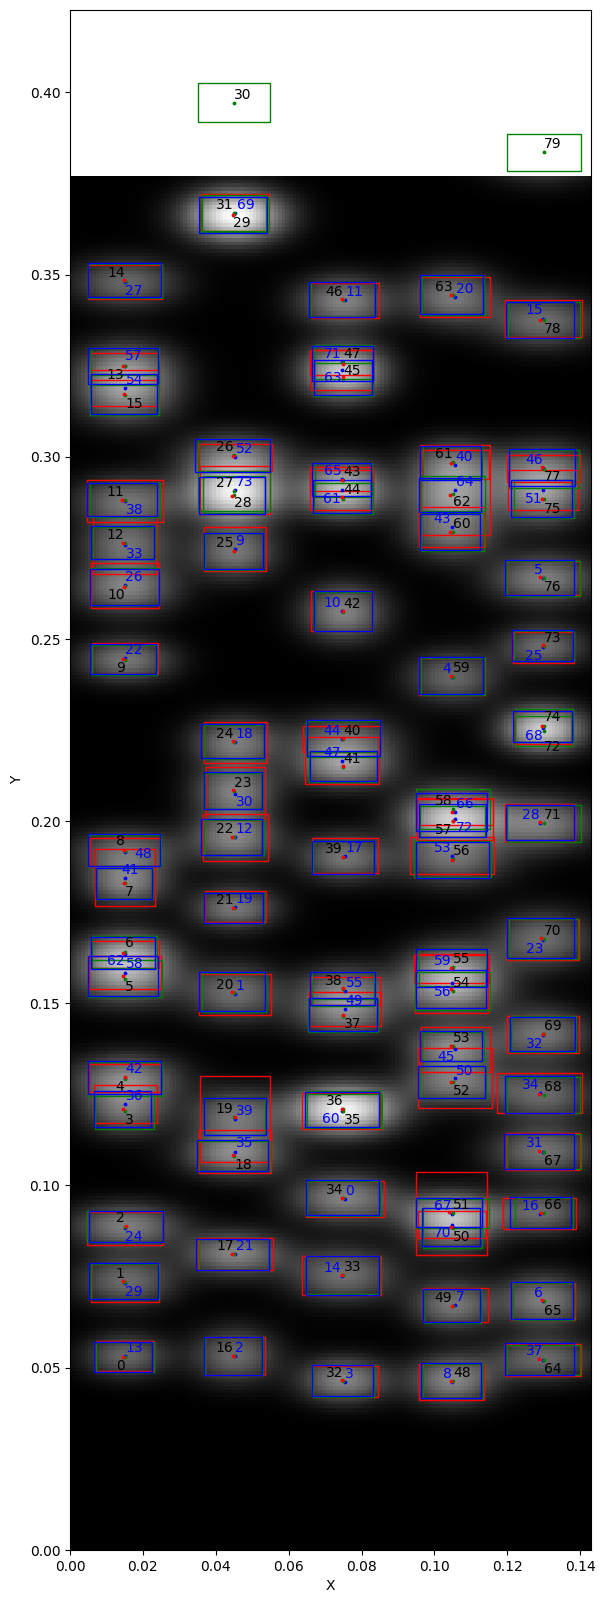

In [ ]:
plt.ion()
plt.show()

### Error evaluation - PX

In [ ]:
# Get number of images that need to be evaluated - YOLO test set
images_test = os.listdir(f"../docs/Models/{NOTEBOOK_CONFIG['model_name']}/datasets/test/images/")
eval_images = [int(i.split('_')[1].split('.')[0]) for i in images_test] # Use the same images of the test from YOLO

In [ ]:
# Iterate all images - GMM method
results = {'Image' : [],
           'Number identified - YOLO_px' : [],
           'Number identifiable - YOLO_px' : [],
           'Percentage - YOLO_px' : [],
           'RMSE_cx - YOLO_px' : [],
           'RMSE_cy - YOLO_px' : [],
           'RMSE_c - YOLO_px' : [],
           'RMSE_sigmax - YOLO_px' : [],
           'RMSE_sigmay - YOLO_px' : [],
           'RMSE_sigma - YOLO_px' : [],
           'MaxE_sigmax - YOLO_px': [],
           'MaxE_sigmay - YOLO_px': [],
           'MaxE_sigma - YOLO_px': [],
           'RMSE_amplitude - YOLO_px': [],
           'RMSEPixel - YOLO_px': []}

for n_image in eval_images:
  eval_gaussian = ppl_error_estimation(n_image,
                                       mat,
                                       estimation_method = "YOLO_px",
                                       image_path = "../docs/Data/Images/",
                                       yolo_model = model,
                                       covariance_gaussians_types = "diag",
                                       return_percentage = True)
  # Append values in the dictionary
  for key in results.keys():
      if key in eval_gaussian:
          results[key] += eval_gaussian[key]


0: 640x256 77 gaussians, 348.4ms
Speed: 1.7ms preprocess, 348.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.011875           0]
  [          0   0.0076213]]]
covariances true [[[   0.011456           0]
  [          0   0.0076081]]]



0: 640x256 77 gaussians, 261.5ms
Speed: 2.1ms preprocess, 261.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.013443           0]
  [          0   0.0072109]]]
covariances true [[[   0.013029           0]
  [          0   0.0069073]]]



0: 640x256 76 gaussians, 275.3ms
Speed: 4.6ms preprocess, 275.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.014623           0]
  [          0   0.0059669]]]
covariances true [[[   0.014005           0]
  [          0    0.005867]]]



0: 640x256 76 gaussians, 435.7ms
Speed: 2.0ms preprocess, 435.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.014398           0]
  [          0   0.0073459]]]
covariances true [[[   0.013057           0]
  [          0   0.0069026]]]



0: 640x256 78 gaussians, 426.4ms
Speed: 1.9ms preprocess, 426.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.012919           0]
  [          0   0.0063217]]]
covariances true [[[   0.012098           0]
  [          0   0.0062757]]]



0: 640x256 76 gaussians, 447.8ms
Speed: 2.6ms preprocess, 447.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[    0.01608           0]
  [          0   0.0076577]]]
covariances true [[[   0.014293           0]
  [          0   0.0073547]]]



0: 640x256 77 gaussians, 423.2ms
Speed: 2.0ms preprocess, 423.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.014563           0]
  [          0   0.0077548]]]
covariances true [[[   0.014285           0]
  [          0   0.0072075]]]



0: 640x256 77 gaussians, 1265.8ms
Speed: 1.9ms preprocess, 1265.8ms inference, 16.2ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.013361           0]
  [          0   0.0070309]]]
covariances true [[[   0.012539           0]
  [          0       0.007]]]



0: 640x256 73 gaussians, 1591.2ms
Speed: 2.0ms preprocess, 1591.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.015334           0]
  [          0   0.0067732]]]
covariances true [[[   0.014311           0]
  [          0   0.0066495]]]



0: 640x256 78 gaussians, 600.7ms
Speed: 1.9ms preprocess, 600.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.013223           0]
  [          0   0.0077556]]]
covariances true [[[   0.012032           0]
  [          0   0.0077143]]]



0: 640x256 77 gaussians, 457.0ms
Speed: 2.0ms preprocess, 457.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.014457           0]
  [          0   0.0074418]]]
covariances true [[[    0.01402           0]
  [          0   0.0072125]]]



0: 640x256 78 gaussians, 429.5ms
Speed: 2.0ms preprocess, 429.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.012202           0]
  [          0   0.0062993]]]
covariances true [[[   0.011448           0]
  [          0   0.0061521]]]



0: 640x256 78 gaussians, 452.5ms
Speed: 2.1ms preprocess, 452.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[    0.01351           0]
  [          0   0.0071123]]]
covariances true [[[   0.012663           0]
  [          0   0.0070102]]]



0: 640x256 77 gaussians, 474.9ms
Speed: 1.9ms preprocess, 474.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.012823           0]
  [          0   0.0077004]]]
covariances true [[[   0.012455           0]
  [          0   0.0073381]]]



0: 640x256 76 gaussians, 277.5ms
Speed: 1.9ms preprocess, 277.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.015343           0]
  [          0   0.0075225]]]
covariances true [[[    0.01359           0]
  [          0   0.0073286]]]



0: 640x256 74 gaussians, 265.6ms
Speed: 2.1ms preprocess, 265.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.014291           0]
  [          0   0.0068978]]]
covariances true [[[   0.013444           0]
  [          0   0.0068116]]]



0: 640x256 75 gaussians, 254.4ms
Speed: 1.9ms preprocess, 254.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.011441           0]
  [          0   0.0074282]]]
covariances true [[[    0.01123           0]
  [          0   0.0070273]]]



0: 640x256 77 gaussians, 289.5ms
Speed: 2.4ms preprocess, 289.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.014477           0]
  [          0   0.0069077]]]
covariances true [[[   0.013454           0]
  [          0   0.0064014]]]



0: 640x256 77 gaussians, 261.4ms
Speed: 2.3ms preprocess, 261.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.014826           0]
  [          0   0.0078642]]]
covariances true [[[   0.014392           0]
  [          0   0.0073371]]]



0: 640x256 76 gaussians, 260.9ms
Speed: 2.8ms preprocess, 260.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.012831           0]
  [          0   0.0064538]]]
covariances true [[[    0.01212           0]
  [          0   0.0063972]]]



0: 640x256 79 gaussians, 281.6ms
Speed: 2.0ms preprocess, 281.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.033874           0]
  [          0   0.0093457]]]
covariances true [[[   0.017368           0]
  [          0   0.0086248]]]



0: 640x256 80 gaussians, 445.7ms
Speed: 2.0ms preprocess, 445.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.021513           0]
  [          0   0.0093687]]]
covariances true [[[   0.016009           0]
  [          0   0.0087787]]]



0: 640x256 80 gaussians, 444.1ms
Speed: 5.7ms preprocess, 444.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.020241           0]
  [          0   0.0095557]]]
covariances true [[[   0.017855           0]
  [          0   0.0089247]]]



0: 640x256 79 gaussians, 680.0ms
Speed: 4.1ms preprocess, 680.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.019688           0]
  [          0   0.0086132]]]
covariances true [[[   0.016302           0]
  [          0   0.0079472]]]



0: 640x256 80 gaussians, 769.6ms
Speed: 2.3ms preprocess, 769.6ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.018307           0]
  [          0   0.0094155]]]
covariances true [[[   0.015694           0]
  [          0   0.0087361]]]



0: 640x256 79 gaussians, 270.6ms
Speed: 4.7ms preprocess, 270.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.017637           0]
  [          0    0.010659]]]
covariances true [[[   0.015138           0]
  [          0   0.0093174]]]



0: 640x256 80 gaussians, 379.3ms
Speed: 5.8ms preprocess, 379.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.019184           0]
  [          0    0.010103]]]
covariances true [[[   0.016268           0]
  [          0   0.0091864]]]



0: 640x256 79 gaussians, 267.7ms
Speed: 2.5ms preprocess, 267.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.023071           0]
  [          0   0.0093984]]]
covariances true [[[    0.01625           0]
  [          0   0.0088413]]]



0: 640x256 79 gaussians, 260.1ms
Speed: 3.8ms preprocess, 260.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.028044           0]
  [          0    0.010158]]]
covariances true [[[   0.016485           0]
  [          0   0.0082784]]]



0: 640x256 80 gaussians, 274.5ms
Speed: 1.5ms preprocess, 274.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.024279           0]
  [          0   0.0088671]]]
covariances true [[[   0.016971           0]
  [          0   0.0081787]]]



0: 640x256 79 gaussians, 251.5ms
Speed: 2.6ms preprocess, 251.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.023175           0]
  [          0    0.010101]]]
covariances true [[[   0.016689           0]
  [          0   0.0090616]]]



0: 640x256 79 gaussians, 268.1ms
Speed: 1.8ms preprocess, 268.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.017016           0]
  [          0   0.0093758]]]
covariances true [[[    0.01503           0]
  [          0   0.0088039]]]



0: 640x256 79 gaussians, 272.9ms
Speed: 2.0ms preprocess, 272.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.019738           0]
  [          0    0.009626]]]
covariances true [[[   0.015653           0]
  [          0   0.0085055]]]



0: 640x256 79 gaussians, 257.7ms
Speed: 2.8ms preprocess, 257.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.018808           0]
  [          0   0.0092681]]]
covariances true [[[   0.015368           0]
  [          0   0.0079957]]]



0: 640x256 79 gaussians, 268.2ms
Speed: 2.6ms preprocess, 268.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.020947           0]
  [          0   0.0090802]]]
covariances true [[[   0.015066           0]
  [          0     0.00857]]]



0: 640x256 79 gaussians, 267.6ms
Speed: 2.0ms preprocess, 267.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.020857           0]
  [          0    0.010753]]]
covariances true [[[   0.015879           0]
  [          0   0.0087753]]]



0: 640x256 80 gaussians, 278.9ms
Speed: 2.8ms preprocess, 278.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.018067           0]
  [          0    0.010081]]]
covariances true [[[   0.015896           0]
  [          0   0.0088842]]]



0: 640x256 79 gaussians, 257.5ms
Speed: 1.6ms preprocess, 257.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.018318           0]
  [          0     0.01004]]]
covariances true [[[   0.015484           0]
  [          0   0.0086454]]]



0: 640x256 81 gaussians, 369.9ms
Speed: 1.9ms preprocess, 369.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.018774           0]
  [          0   0.0093099]]]
covariances true [[[    0.01689           0]
  [          0   0.0086072]]]



0: 640x256 79 gaussians, 530.2ms
Speed: 1.9ms preprocess, 530.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.021737           0]
  [          0   0.0097289]]]
covariances true [[[   0.017898           0]
  [          0    0.009004]]]


In [ ]:
pd.DataFrame.from_dict(results).describe().round(2).loc[['mean', 'std', 'max']].T

,mean,std,max
Image,218.95,124.81,399.00
Number identified - YOLO_px,77.95,1.78,81.00
Number identifiable - YOLO_px,79.05,0.55,80.00
Percentage - YOLO_px,98.61,2.23,102.53
RMSE_cx - YOLO_px,1.55,1.00,3.18
RMSE_cy - YOLO_px,0.37,0.06,0.60
RMSE_c - YOLO_px,1.62,0.95,3.24
RMSE_sigmax - YOLO_px,23.91,18.36,74.28
RMSE_sigmay - YOLO_px,24.54,9.31,58.41
RMSE_sigma - YOLO_px,37.77,12.82,76.99


In [ ]:
# SNAPSHOTS THE RESULTS WITH THE ANNOTATIONS
snapshot_folder_path = f"""../docs/Results/snapshot_v{str(datetime.now().date())}/"""

# Save for Yolo
checkpoint_error(snapshot_folder_path = snapshot_folder_path,
                 error_dataframe = pd.DataFrame.from_dict(results).sort_values('Image'),
                 annotation = f"""Amplitudes estimated using the center directly\n
                 image_path = {"../docs/Data/Images/"}\n
                 id_estimation_method = {model.__dict__['ckpt_path']}\n
                 id_images evaluated: {eval_images}""",
                 name = "E12YOLOPX")

## Evaluate - Plot Truth, YOLO and PX infer - PX Modified 2

In [ ]:
# Create subplots
plt.ioff()
fig, ax = plt.subplots(1, figsize = (25, 20))
all_texts = []

In [ ]:
# Original image
plot_grayscale(x, y, mat['F_data'][:,:, n_image],
               colorbar = False,
               ax = ax)

In [ ]:
# Plot box and center - from pipeline with PX estimation covariance
all_texts = all_texts + plot_box_labels(image,
                                  [(x, y) for x, y in converted_new_means_infer],
                                  [(wx, wy) for wx, wy in
                                   zip(np.sqrt(new_covariances_infer[:, 0, 0]),
                                       np.sqrt(new_covariances_infer[:, 1, 1]))],
                                  ax = ax,
                                  center_color = 'b', # CENTER COLOR
                                  annotate_gaussians = True,
                                  text_color = 'blue')

In [ ]:
# Plot box and center - TRUE
all_texts = all_texts + plot_box_labels(image,
                                        list(zip(xs, ys)),
                                        list(zip(dispersion_x, dispersion_y)),
                                        ax = ax,
                                        box_edge_color = 'g', # BOX COLOR
                                        center_color = 'g', # CENTER COLOR
                                        annotate_gaussians = True)

In [ ]:
# Plot box and center -  YOLO
plot_box_labels(image,
                [(x, y) for x, y in means],
                [(wx, wy) for wx, wy in
                  zip(np.sqrt(covariances[:, 0, 0]),
                      np.sqrt(covariances[:, 1, 1]))],
                ax = ax,
                box_edge_color = 'b', # BOX COLOR
                center_color = 'red', # CENTER COLOR
                annotate_gaussians = False)

In [ ]:
ax.xaxis.label.set_text("")
ax.yaxis.label.set_text("")

ax.set_xticks([])
ax.set_yticks([])
# Change the color of the axis spines (borders)
for spine in ax.spines.values():
    spine.set_edgecolor('gray')
    spine.set_linewidth(1)

ax.set_ylim(0, NOTEBOOK_CONFIG['IMG_LENGTH'])
ax.set_xlim(0, NOTEBOOK_CONFIG['IMG_WIDTH'])

In [ ]:
adjust_text(all_texts)

10

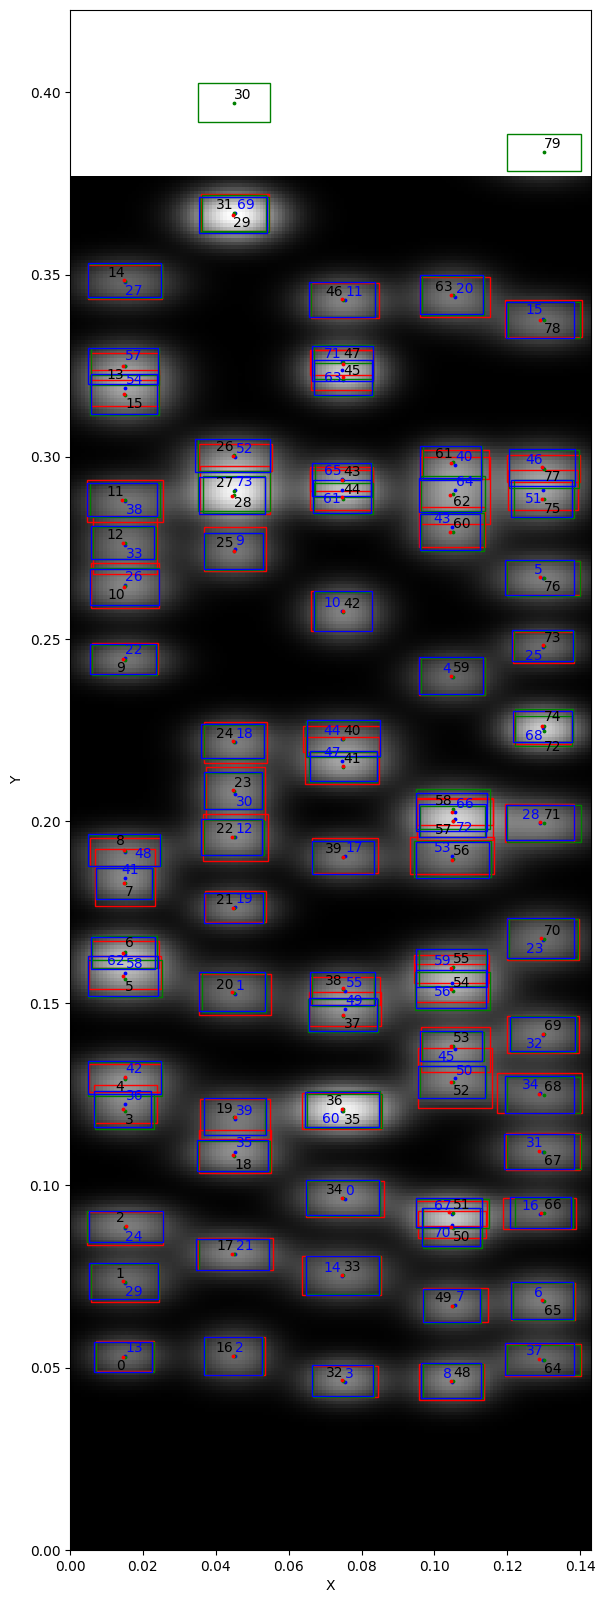

In [ ]:
plt.ion()
plt.show()

### Error evaluation - PX Infer

In [ ]:
# Get number of images that need to be evaluated - YOLO test set
images_test = os.listdir(f"../docs/Models/{NOTEBOOK_CONFIG['model_name']}/datasets/test/images/")
eval_images = [int(i.split('_')[1].split('.')[0]) for i in images_test] # Use the same images of the test from YOLO

In [ ]:
print(eval_images)

[156, 74, 6, 60, 166, 128, 88, 65, 177, 176, 37, 116, 39, 188, 110, 98, 62, 93, 178, 149, 364, 386, 345, 367, 398, 385, 348, 399, 308, 290, 205, 340, 295, 269, 395, 246, 292, 352, 354, 254]


In [ ]:
# Iterate all images - GMM method
results = {'Image' : [],
           'Number identified - YOLO_px_infer' : [],
           'Number identifiable - YOLO_px_infer' : [],
           'Percentage - YOLO_px_infer' : [],
           'RMSE_cx - YOLO_px_infer' : [],
           'RMSE_cy - YOLO_px_infer' : [],
           'RMSE_c - YOLO_px_infer' : [],
           'RMSE_sigmax - YOLO_px_infer' : [],
           'RMSE_sigmay - YOLO_px_infer' : [],
           'RMSE_sigma - YOLO_px_infer' : [],
           'MaxE_sigmax - YOLO_px_infer': [],
           'MaxE_sigmay - YOLO_px_infer': [],
           'MaxE_sigma - YOLO_px_infer': [],
           'RMSE_amplitude - YOLO_px_infer': [],
           'RMSEPixel - YOLO_px_infer': []}

for n_image in eval_images:
  eval_gaussian = ppl_error_estimation(n_image,
                                       mat,
                                       estimation_method = "YOLO_px_infer",
                                       image_path = "../docs/Data/Images/",
                                       yolo_model = model,
                                       covariance_gaussians_types = "diag",
                                       return_percentage = True)
  # Append values in the dictionary
  for key in results.keys():
      if key in eval_gaussian:
          results[key] += eval_gaussian[key]


0: 640x256 77 gaussians, 326.1ms
Speed: 3.5ms preprocess, 326.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.011875           0]
  [          0   0.0076213]]]
covariances true [[[   0.011456           0]
  [          0   0.0076081]]]



0: 640x256 77 gaussians, 252.4ms
Speed: 2.0ms preprocess, 252.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.013443           0]
  [          0   0.0072109]]]
covariances true [[[   0.013029           0]
  [          0   0.0069073]]]



0: 640x256 76 gaussians, 257.2ms
Speed: 4.8ms preprocess, 257.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.014623           0]
  [          0   0.0059669]]]
covariances true [[[   0.014005           0]
  [          0    0.005867]]]



0: 640x256 76 gaussians, 250.1ms
Speed: 5.1ms preprocess, 250.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.014398           0]
  [          0   0.0073459]]]
covariances true [[[   0.013057           0]
  [          0   0.0069026]]]



0: 640x256 78 gaussians, 265.6ms
Speed: 1.9ms preprocess, 265.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.012919           0]
  [          0   0.0063217]]]
covariances true [[[   0.012098           0]
  [          0   0.0062757]]]



0: 640x256 76 gaussians, 263.7ms
Speed: 2.1ms preprocess, 263.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[    0.01608           0]
  [          0   0.0076577]]]
covariances true [[[   0.014293           0]
  [          0   0.0073547]]]



0: 640x256 77 gaussians, 255.4ms
Speed: 2.6ms preprocess, 255.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.014563           0]
  [          0   0.0077548]]]
covariances true [[[   0.014285           0]
  [          0   0.0072075]]]



0: 640x256 77 gaussians, 572.2ms
Speed: 3.7ms preprocess, 572.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.013361           0]
  [          0   0.0070309]]]
covariances true [[[   0.012539           0]
  [          0       0.007]]]



0: 640x256 73 gaussians, 477.5ms
Speed: 2.3ms preprocess, 477.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.015334           0]
  [          0   0.0067732]]]
covariances true [[[   0.014311           0]
  [          0   0.0066495]]]



0: 640x256 78 gaussians, 378.2ms
Speed: 2.1ms preprocess, 378.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.013223           0]
  [          0   0.0077556]]]
covariances true [[[   0.012032           0]
  [          0   0.0077143]]]



0: 640x256 77 gaussians, 761.2ms
Speed: 4.8ms preprocess, 761.2ms inference, 8.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.014457           0]
  [          0   0.0074418]]]
covariances true [[[    0.01402           0]
  [          0   0.0072125]]]



0: 640x256 78 gaussians, 873.5ms
Speed: 2.0ms preprocess, 873.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.012202           0]
  [          0   0.0062993]]]
covariances true [[[   0.011448           0]
  [          0   0.0061521]]]



0: 640x256 78 gaussians, 765.9ms
Speed: 1.9ms preprocess, 765.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[    0.01351           0]
  [          0   0.0071123]]]
covariances true [[[   0.012663           0]
  [          0   0.0070102]]]



0: 640x256 77 gaussians, 502.0ms
Speed: 1.9ms preprocess, 502.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.012823           0]
  [          0   0.0077004]]]
covariances true [[[   0.012455           0]
  [          0   0.0073381]]]



0: 640x256 76 gaussians, 460.7ms
Speed: 2.0ms preprocess, 460.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.015343           0]
  [          0   0.0075225]]]
covariances true [[[    0.01359           0]
  [          0   0.0073286]]]



0: 640x256 74 gaussians, 264.8ms
Speed: 2.6ms preprocess, 264.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.014291           0]
  [          0   0.0068978]]]
covariances true [[[   0.013444           0]
  [          0   0.0068116]]]



0: 640x256 75 gaussians, 280.7ms
Speed: 4.3ms preprocess, 280.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.011441           0]
  [          0   0.0074282]]]
covariances true [[[    0.01123           0]
  [          0   0.0070273]]]



0: 640x256 77 gaussians, 251.1ms
Speed: 1.9ms preprocess, 251.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.014477           0]
  [          0   0.0069077]]]
covariances true [[[   0.013454           0]
  [          0   0.0064014]]]



0: 640x256 77 gaussians, 261.8ms
Speed: 4.0ms preprocess, 261.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.014826           0]
  [          0   0.0078642]]]
covariances true [[[   0.014392           0]
  [          0   0.0073371]]]



0: 640x256 76 gaussians, 411.2ms
Speed: 2.2ms preprocess, 411.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.012831           0]
  [          0   0.0064538]]]
covariances true [[[    0.01212           0]
  [          0   0.0063972]]]



0: 640x256 79 gaussians, 302.5ms
Speed: 1.9ms preprocess, 302.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.033874           0]
  [          0   0.0093457]]]
covariances true [[[   0.017368           0]
  [          0   0.0086248]]]



0: 640x256 80 gaussians, 463.0ms
Speed: 4.6ms preprocess, 463.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-11-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.021513           0]
  [          0   0.0093687]]]
covariances true [[[   0.016009           0]
  [          0   0.0087787]]]



0: 640x256 80 gaussians, 434.4ms
Speed: 1.9ms preprocess, 434.4ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-11-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.020241           0]
  [          0   0.0095557]]]
covariances true [[[   0.017855           0]
  [          0   0.0089247]]]



0: 640x256 79 gaussians, 326.1ms
Speed: 1.9ms preprocess, 326.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.019688           0]
  [          0   0.0086132]]]
covariances true [[[   0.016302           0]
  [          0   0.0079472]]]



0: 640x256 80 gaussians, 1053.7ms
Speed: 1.9ms preprocess, 1053.7ms inference, 14.3ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-11-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.018307           0]
  [          0   0.0094155]]]
covariances true [[[   0.015694           0]
  [          0   0.0087361]]]



0: 640x256 79 gaussians, 1627.4ms
Speed: 1.9ms preprocess, 1627.4ms inference, 8.9ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.017637           0]
  [          0    0.010659]]]
covariances true [[[   0.015138           0]
  [          0   0.0093174]]]



0: 640x256 80 gaussians, 533.0ms
Speed: 2.0ms preprocess, 533.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-11-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.019184           0]
  [          0    0.010103]]]
covariances true [[[   0.016268           0]
  [          0   0.0091864]]]



0: 640x256 79 gaussians, 430.4ms
Speed: 3.8ms preprocess, 430.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.023071           0]
  [          0   0.0093984]]]
covariances true [[[    0.01625           0]
  [          0   0.0088413]]]



0: 640x256 79 gaussians, 418.1ms
Speed: 2.5ms preprocess, 418.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.028044           0]
  [          0    0.010158]]]
covariances true [[[   0.016485           0]
  [          0   0.0082784]]]



0: 640x256 80 gaussians, 407.1ms
Speed: 2.2ms preprocess, 407.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-11-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.024279           0]
  [          0   0.0088671]]]
covariances true [[[   0.016971           0]
  [          0   0.0081787]]]



0: 640x256 79 gaussians, 269.6ms
Speed: 2.0ms preprocess, 269.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.023175           0]
  [          0    0.010101]]]
covariances true [[[   0.016689           0]
  [          0   0.0090616]]]



0: 640x256 79 gaussians, 260.6ms
Speed: 1.9ms preprocess, 260.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.017016           0]
  [          0   0.0093758]]]
covariances true [[[    0.01503           0]
  [          0   0.0088039]]]



0: 640x256 79 gaussians, 265.1ms
Speed: 2.2ms preprocess, 265.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.019738           0]
  [          0    0.009626]]]
covariances true [[[   0.015653           0]
  [          0   0.0085055]]]



0: 640x256 79 gaussians, 250.5ms
Speed: 2.3ms preprocess, 250.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.018808           0]
  [          0   0.0092681]]]
covariances true [[[   0.015368           0]
  [          0   0.0079957]]]



0: 640x256 79 gaussians, 252.8ms
Speed: 2.2ms preprocess, 252.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.020947           0]
  [          0   0.0090802]]]
covariances true [[[   0.015066           0]
  [          0     0.00857]]]



0: 640x256 79 gaussians, 263.3ms
Speed: 1.8ms preprocess, 263.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.020857           0]
  [          0    0.010753]]]
covariances true [[[   0.015879           0]
  [          0   0.0087753]]]



0: 640x256 80 gaussians, 252.7ms
Speed: 4.5ms preprocess, 252.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-11-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.018067           0]
  [          0    0.010081]]]
covariances true [[[   0.015896           0]
  [          0   0.0088842]]]



0: 640x256 79 gaussians, 1601.5ms
Speed: 1.9ms preprocess, 1601.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.018318           0]
  [          0     0.01004]]]
covariances true [[[   0.015484           0]
  [          0   0.0086454]]]



0: 640x256 81 gaussians, 446.7ms
Speed: 1.9ms preprocess, 446.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-11-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.018774           0]
  [          0   0.0093099]]]
covariances true [[[    0.01689           0]
  [          0   0.0086072]]]



0: 640x256 79 gaussians, 447.6ms
Speed: 1.8ms preprocess, 447.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.021737           0]
  [          0   0.0097289]]]
covariances true [[[   0.017898           0]
  [          0    0.009004]]]


In [ ]:
pd.DataFrame.from_dict(results).describe().round(2).loc[['mean', 'std', 'max']].T

,mean,std,max
Image,218.95,124.81,399.00
Number identified - YOLO_px_infer,77.95,1.78,81.00
Number identifiable - YOLO_px_infer,79.05,0.55,80.00
Percentage - YOLO_px_infer,98.61,2.23,102.53
RMSE_cx - YOLO_px_infer,1.55,1.00,3.18
RMSE_cy - YOLO_px_infer,0.37,0.06,0.60
RMSE_c - YOLO_px_infer,1.62,0.95,3.24
RMSE_sigmax - YOLO_px_infer,15.18,8.70,26.44
RMSE_sigmay - YOLO_px_infer,14.63,2.56,24.89
RMSE_sigma - YOLO_px_infer,21.99,6.49,30.59


In [ ]:
# SNAPSHOTS THE RESULTS WITH THE ANNOTATIONS
snapshot_folder_path = f"""../docs/Results/snapshot_v{str(datetime.now().date())}/"""

# Save for Yolo
checkpoint_error(snapshot_folder_path = snapshot_folder_path,
                 error_dataframe = pd.DataFrame.from_dict(results).sort_values('Image'),
                 annotation = f"""Amplitudes estimated using the center directly\n
                 image_path = {"../docs/Data/Images/"}\n
                 id_estimation_method = {model.__dict__['ckpt_path']}\n
                 id_images evaluated: {eval_images}""",
                 name = "E12YOLOPXINFER")

## [ESTIMATION] Pipeline ensembled (PX Modified and YOLO)

In [ ]:
# Image - z intensities
image = [x,
         y,
         mat['F_data'][:,:, n_image]]

# Parameters extraction
(amplitude,
 xs,
 ys,
 dispersion_x,
 dispersion_y) = parameters_extract(mat['Fit_flux'], n_image)

#### ERROR MSEP evaluation - YOLO + Refinning -
- Compare values by reconstruction with the estimated parameters (per Gaussian)

##### Each Gaussian error estimation

In [ ]:
# Sanity check truth
means_truth = list(zip(xs, ys))
covariances_truth = [np.array([[(wx/(np.sqrt(2)))**2, 0],
                               [0, (wy/(np.sqrt(2)))**2]]) for
                     wx, wy in zip(dispersion_x, dispersion_y)]
amplitudes_truth = amplitude
(all_gaussians_truth,
 generated_z_truth,
 rmsep_truth,
 error_gaussians_truth) = compute_error_per_gaussian(image,
                                                     means_truth,
                                                     covariances_truth,
                                                     amplitudes_truth)

Gaussian 30 center is out of bounds
Gaussian 79 center is out of bounds


In [ ]:
# Compute YOLO
(all_gaussians_yolo,
 generated_z_yolo,
 rmsep_yolo,
 error_gaussians_yolo) = compute_error_per_gaussian(image,
                                                    means,
                                                    list(covariances/2),
                                                    amplitudes_yolo)

In [ ]:
# Compute YOLO + PX
(all_gaussians_px,
 generated_z_px,
 rmsep_px,
 error_gaussians_px) = compute_error_per_gaussian(image,
                                                  converted_new_means,
                                                  list(new_covariances/2),
                                                  amplitudes_px)

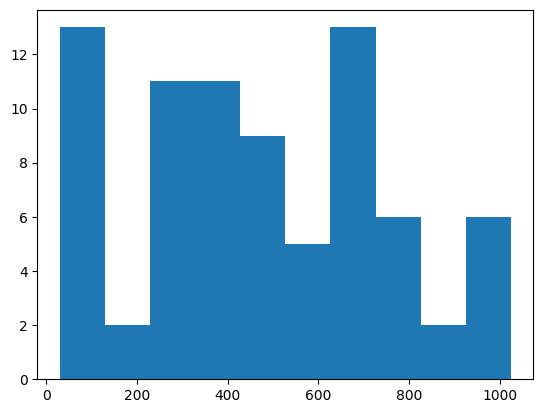

In [ ]:
# Error Yolo
plt.hist(error_gaussians_truth)
plt.show()

Max error gaussian = 72
Min error gaussian = 14


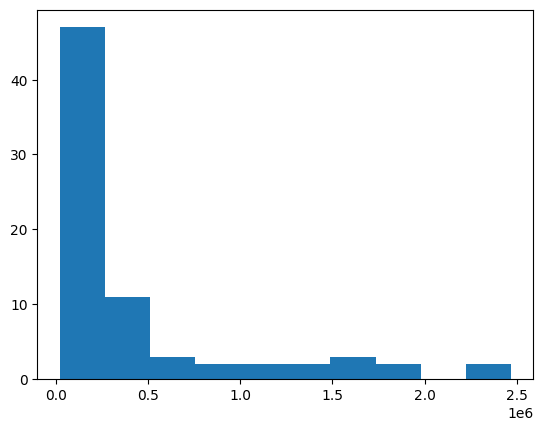

In [ ]:
# Error Yolo
plt.hist(error_gaussians_yolo)

# Gaussian min / max error
print(f'Max error gaussian = {np.argmax(np.array(error_gaussians_yolo))}')
print(f'Min error gaussian = {np.argmin(np.array(error_gaussians_yolo))}')

Max error gaussian = 70
Min error gaussian = 27


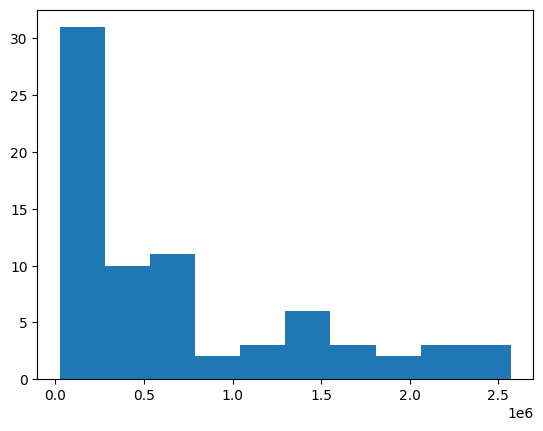

In [ ]:
# Error PX
plt.hist(error_gaussians_px)

# Gaussian min / max error
print(f'Max error gaussian = {np.argmax(np.array(error_gaussians_px))}')
print(f'Min error gaussian = {np.argmin(np.array(error_gaussians_px))}')

### Error evaluation ensemble Yolo and PX

In [ ]:
# Get number of images that need to be evaluated - YOLO test set
images_test = os.listdir(f"../docs/Models/{NOTEBOOK_CONFIG['model_name']}/datasets/test/images/")
eval_images = [int(i.split('_')[1].split('.')[0]) for i in images_test] # Use the same images of the test from YOLO

In [ ]:
print(eval_images)

[156, 74, 6, 60, 166, 128, 88, 65, 177, 176, 37, 116, 39, 188, 110, 98, 62, 93, 178, 149, 364, 386, 345, 367, 398, 385, 348, 399, 308, 290, 205, 340, 295, 269, 395, 246, 292, 352, 354, 254]


In [ ]:
# Iterate all images - ensembled method
results = {'Image' : [],
           'Number identified - ensembled' : [],
           'Number identifiable - ensembled' : [],
           'Percentage - ensembled' : [],
           'RMSE_cx - ensembled' : [],
           'RMSE_cy - ensembled' : [],
           'RMSE_c - ensembled' : [],
           'RMSE_sigmax - ensembled' : [],
           'RMSE_sigmay - ensembled' : [],
           'RMSE_sigma - ensembled' : [],
           'MaxE_sigmax - ensembled': [],
           'MaxE_sigmay - ensembled': [],
           'MaxE_sigma - ensembled': [],
           'RMSE_amplitude - ensembled': [],
           'RMSEPixel - ensembled': []}

for n_image in eval_images:
  eval_gaussian = ppl_error_estimation(n_image,
                                       mat,
                                       image_path = "../docs/Data/Images/",
                                       peak_method = 'laplace',
                                       yolo_model = model,
                                       estimation_method = ["YOLO", "YOLO_px"],
                                       covariance_gaussians_types = "diag",
                                       return_percentage = True)
  # Append values in the dictionary
  for key in results.keys():
      if key in eval_gaussian:
          results[key] += eval_gaussian[key]


0: 640x256 77 gaussians, 528.3ms
Speed: 2.1ms preprocess, 528.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 77 gaussians, 447.5ms
Speed: 1.9ms preprocess, 447.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[    0.01152           0]
  [          0   0.0076559]]]
covariances true [[[   0.011456           0]
  [          0   0.0076081]]]



0: 640x256 77 gaussians, 446.5ms
Speed: 2.0ms preprocess, 446.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 77 gaussians, 446.0ms
Speed: 2.0ms preprocess, 446.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.013246           0]
  [          0   0.0068977]]]
covariances true [[[   0.013029           0]
  [          0   0.0069073]]]



0: 640x256 76 gaussians, 1060.2ms
Speed: 2.4ms preprocess, 1060.2ms inference, 11.5ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 76 gaussians, 418.0ms
Speed: 1.9ms preprocess, 418.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.014082           0]
  [          0    0.005895]]]
covariances true [[[   0.014005           0]
  [          0    0.005867]]]



0: 640x256 76 gaussians, 865.3ms
Speed: 2.0ms preprocess, 865.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 76 gaussians, 1462.8ms
Speed: 2.5ms preprocess, 1462.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.013251           0]
  [          0   0.0067876]]]
covariances true [[[   0.013057           0]
  [          0   0.0069026]]]



0: 640x256 78 gaussians, 745.2ms
Speed: 3.3ms preprocess, 745.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 78 gaussians, 551.9ms
Speed: 2.6ms preprocess, 551.9ms inference, 10.7ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.012262           0]
  [          0   0.0063411]]]
covariances true [[[   0.012098           0]
  [          0   0.0062757]]]



0: 640x256 76 gaussians, 694.8ms
Speed: 2.0ms preprocess, 694.8ms inference, 11.9ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 76 gaussians, 1259.9ms
Speed: 4.5ms preprocess, 1259.9ms inference, 9.1ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.014357           0]
  [          0   0.0073565]]]
covariances true [[[   0.014293           0]
  [          0   0.0073547]]]



0: 640x256 77 gaussians, 589.0ms
Speed: 2.3ms preprocess, 589.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 77 gaussians, 1103.8ms
Speed: 2.1ms preprocess, 1103.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.014419           0]
  [          0   0.0072034]]]
covariances true [[[   0.014285           0]
  [          0   0.0072075]]]



0: 640x256 77 gaussians, 625.3ms
Speed: 2.0ms preprocess, 625.3ms inference, 4.6ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 77 gaussians, 454.8ms
Speed: 2.0ms preprocess, 454.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.012577           0]
  [          0   0.0071186]]]
covariances true [[[   0.012539           0]
  [          0       0.007]]]



0: 640x256 73 gaussians, 417.6ms
Speed: 1.9ms preprocess, 417.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 73 gaussians, 455.3ms
Speed: 4.8ms preprocess, 455.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.014498           0]
  [          0   0.0066782]]]
covariances true [[[   0.014311           0]
  [          0   0.0066495]]]



0: 640x256 78 gaussians, 459.1ms
Speed: 2.0ms preprocess, 459.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 78 gaussians, 253.5ms
Speed: 2.5ms preprocess, 253.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[    0.01208           0]
  [          0   0.0077728]]]
covariances true [[[   0.012032           0]
  [          0   0.0077143]]]



0: 640x256 77 gaussians, 279.4ms
Speed: 2.5ms preprocess, 279.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 77 gaussians, 273.1ms
Speed: 2.1ms preprocess, 273.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.014071           0]
  [          0   0.0072587]]]
covariances true [[[    0.01402           0]
  [          0   0.0072125]]]



0: 640x256 78 gaussians, 268.0ms
Speed: 1.8ms preprocess, 268.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 78 gaussians, 270.0ms
Speed: 2.9ms preprocess, 270.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.011617           0]
  [          0   0.0062129]]]
covariances true [[[   0.011448           0]
  [          0   0.0061521]]]



0: 640x256 78 gaussians, 446.8ms
Speed: 1.9ms preprocess, 446.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 78 gaussians, 446.2ms
Speed: 1.9ms preprocess, 446.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.012757           0]
  [          0   0.0070232]]]
covariances true [[[   0.012663           0]
  [          0   0.0070102]]]



0: 640x256 77 gaussians, 453.6ms
Speed: 2.0ms preprocess, 453.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 77 gaussians, 449.0ms
Speed: 4.4ms preprocess, 449.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.012485           0]
  [          0   0.0072914]]]
covariances true [[[   0.012455           0]
  [          0   0.0073381]]]



0: 640x256 76 gaussians, 253.8ms
Speed: 2.2ms preprocess, 253.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 76 gaussians, 266.8ms
Speed: 1.5ms preprocess, 266.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.013652           0]
  [          0   0.0073498]]]
covariances true [[[    0.01359           0]
  [          0   0.0073286]]]



0: 640x256 74 gaussians, 267.5ms
Speed: 2.1ms preprocess, 267.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 74 gaussians, 256.6ms
Speed: 2.2ms preprocess, 256.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.013539           0]
  [          0   0.0068485]]]
covariances true [[[   0.013444           0]
  [          0   0.0068116]]]



0: 640x256 75 gaussians, 257.9ms
Speed: 1.5ms preprocess, 257.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 75 gaussians, 264.8ms
Speed: 2.2ms preprocess, 264.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.011324           0]
  [          0   0.0071303]]]
covariances true [[[    0.01123           0]
  [          0   0.0070273]]]



0: 640x256 77 gaussians, 268.4ms
Speed: 2.8ms preprocess, 268.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 77 gaussians, 258.4ms
Speed: 5.2ms preprocess, 258.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.013536           0]
  [          0   0.0064495]]]
covariances true [[[   0.013454           0]
  [          0   0.0064014]]]



0: 640x256 77 gaussians, 264.6ms
Speed: 2.0ms preprocess, 264.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 77 gaussians, 265.0ms
Speed: 2.0ms preprocess, 265.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.013752           0]
  [          0   0.0075211]]]
covariances true [[[   0.014392           0]
  [          0   0.0073371]]]



0: 640x256 76 gaussians, 268.0ms
Speed: 2.9ms preprocess, 268.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 76 gaussians, 312.1ms
Speed: 1.9ms preprocess, 312.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.012209           0]
  [          0   0.0064438]]]
covariances true [[[    0.01212           0]
  [          0   0.0063972]]]



0: 640x256 79 gaussians, 1089.3ms
Speed: 1.9ms preprocess, 1089.3ms inference, 9.2ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 79 gaussians, 460.5ms
Speed: 1.9ms preprocess, 460.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.017047           0]
  [          0     0.00863]]]
covariances true [[[   0.017368           0]
  [          0   0.0086248]]]



0: 640x256 80 gaussians, 258.1ms
Speed: 1.8ms preprocess, 258.1ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 80 gaussians, 282.2ms
Speed: 2.0ms preprocess, 282.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.015922           0]
  [          0   0.0088045]]]
covariances true [[[   0.016009           0]
  [          0   0.0087787]]]



0: 640x256 80 gaussians, 276.8ms
Speed: 1.9ms preprocess, 276.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 80 gaussians, 256.1ms
Speed: 2.0ms preprocess, 256.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.017749           0]
  [          0   0.0088854]]]
covariances true [[[   0.017855           0]
  [          0   0.0089247]]]



0: 640x256 79 gaussians, 260.5ms
Speed: 3.0ms preprocess, 260.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 79 gaussians, 272.9ms
Speed: 2.2ms preprocess, 272.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.016311           0]
  [          0   0.0079236]]]
covariances true [[[   0.016302           0]
  [          0   0.0079472]]]



0: 640x256 80 gaussians, 267.1ms
Speed: 2.3ms preprocess, 267.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 80 gaussians, 267.0ms
Speed: 2.5ms preprocess, 267.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.015779           0]
  [          0   0.0087974]]]
covariances true [[[   0.015694           0]
  [          0   0.0087361]]]



0: 640x256 79 gaussians, 272.9ms
Speed: 1.8ms preprocess, 272.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 79 gaussians, 253.6ms
Speed: 2.2ms preprocess, 253.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.015254           0]
  [          0   0.0093527]]]
covariances true [[[   0.015138           0]
  [          0   0.0093174]]]



0: 640x256 80 gaussians, 262.5ms
Speed: 2.6ms preprocess, 262.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 80 gaussians, 255.2ms
Speed: 2.0ms preprocess, 255.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.016462           0]
  [          0   0.0091977]]]
covariances true [[[   0.016268           0]
  [          0   0.0091864]]]



0: 640x256 79 gaussians, 445.7ms
Speed: 2.3ms preprocess, 445.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 79 gaussians, 438.6ms
Speed: 1.9ms preprocess, 438.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.016274           0]
  [          0   0.0088483]]]
covariances true [[[    0.01625           0]
  [          0   0.0088413]]]



0: 640x256 79 gaussians, 446.4ms
Speed: 1.9ms preprocess, 446.4ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 79 gaussians, 768.5ms
Speed: 1.9ms preprocess, 768.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.016577           0]
  [          0   0.0082585]]]
covariances true [[[   0.016485           0]
  [          0   0.0082784]]]



0: 640x256 80 gaussians, 268.1ms
Speed: 2.0ms preprocess, 268.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 80 gaussians, 270.4ms
Speed: 2.9ms preprocess, 270.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.016877           0]
  [          0     0.00824]]]
covariances true [[[   0.016971           0]
  [          0   0.0081787]]]



0: 640x256 79 gaussians, 272.7ms
Speed: 5.2ms preprocess, 272.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 79 gaussians, 259.6ms
Speed: 4.4ms preprocess, 259.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[    0.01471           0]
  [          0    0.009004]]]
covariances true [[[   0.016689           0]
  [          0   0.0090616]]]



0: 640x256 79 gaussians, 261.9ms
Speed: 2.0ms preprocess, 261.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 79 gaussians, 262.7ms
Speed: 1.8ms preprocess, 262.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.015123           0]
  [          0   0.0088901]]]
covariances true [[[    0.01503           0]
  [          0   0.0088039]]]



0: 640x256 79 gaussians, 263.6ms
Speed: 1.6ms preprocess, 263.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 79 gaussians, 276.2ms
Speed: 2.6ms preprocess, 276.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.015693           0]
  [          0   0.0085176]]]
covariances true [[[   0.015653           0]
  [          0   0.0085055]]]



0: 640x256 79 gaussians, 287.9ms
Speed: 5.7ms preprocess, 287.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 79 gaussians, 342.1ms
Speed: 3.3ms preprocess, 342.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.015486           0]
  [          0   0.0081205]]]
covariances true [[[   0.015368           0]
  [          0   0.0079957]]]



0: 640x256 79 gaussians, 813.0ms
Speed: 2.0ms preprocess, 813.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 79 gaussians, 1325.0ms
Speed: 1.9ms preprocess, 1325.0ms inference, 18.9ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.015414           0]
  [          0   0.0086324]]]
covariances true [[[   0.015066           0]
  [          0     0.00857]]]



0: 640x256 79 gaussians, 300.2ms
Speed: 2.4ms preprocess, 300.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 79 gaussians, 295.0ms
Speed: 2.8ms preprocess, 295.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.016028           0]
  [          0   0.0088321]]]
covariances true [[[   0.015879           0]
  [          0   0.0087753]]]



0: 640x256 80 gaussians, 467.4ms
Speed: 2.0ms preprocess, 467.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 80 gaussians, 467.9ms
Speed: 2.2ms preprocess, 467.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.015783           0]
  [          0   0.0088333]]]
covariances true [[[   0.015896           0]
  [          0   0.0088842]]]



0: 640x256 79 gaussians, 444.8ms
Speed: 2.1ms preprocess, 444.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 79 gaussians, 464.5ms
Speed: 1.9ms preprocess, 464.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.015536           0]
  [          0   0.0087228]]]
covariances true [[[   0.015484           0]
  [          0   0.0086454]]]



0: 640x256 81 gaussians, 795.5ms
Speed: 1.9ms preprocess, 795.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 81 gaussians, 447.0ms
Speed: 2.0ms preprocess, 447.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.017151           0]
  [          0   0.0086221]]]
covariances true [[[    0.01689           0]
  [          0   0.0086072]]]



0: 640x256 79 gaussians, 452.6ms
Speed: 1.9ms preprocess, 452.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 79 gaussians, 439.2ms
Speed: 2.1ms preprocess, 439.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.017853           0]
  [          0   0.0089644]]]
covariances true [[[   0.017898           0]
  [          0    0.009004]]]


In [ ]:
pd.DataFrame.from_dict(results).describe().round(2).loc[['mean', 'std', 'max']].T

,mean,std,max
Image,218.95,124.81,399.00
Number identified - ensembled,77.95,1.78,81.00
Number identifiable - ensembled,79.05,0.55,80.00
Percentage - ensembled,98.61,2.23,102.53
RMSE_cx - ensembled,1.67,0.72,3.58
RMSE_cy - ensembled,0.09,0.04,0.32
RMSE_c - ensembled,1.68,0.72,3.60
RMSE_sigmax - ensembled,4.25,2.66,8.67
RMSE_sigmay - ensembled,1.91,0.64,3.30
RMSE_sigma - ensembled,4.86,2.35,9.10


In [ ]:
# Results
pd.DataFrame.from_dict(results).round(2).sort_values('Image')

,Image,Number identified - ensembled,Number identifiable - ensembled,Percentage - ensembled,RMSE_cx - ensembled,RMSE_cy - ensembled,RMSE_c - ensembled,RMSE_sigmax - ensembled,RMSE_sigmay - ensembled,RMSE_sigma - ensembled,MaxE_sigmax - ensembled,MaxE_sigmay - ensembled,MaxE_sigma - ensembled,RMSE_amplitude - ensembled,RMSEPixel - ensembled
2,6,76,79,96.20,0.99,0.06,1.00,1.61,1.55,2.23,6.73,8.61,10.93,22.72,535065.66
10,37,77,78,98.72,0.89,0.08,0.90,1.68,2.51,3.02,10.46,52.74,53.77,21.80,476897.49
12,39,78,80,97.50,0.90,0.08,0.91,1.34,1.69,2.16,8.70,20.67,22.42,20.06,454391.95
3,60,76,79,96.20,1.02,0.10,1.03,1.87,1.89,2.66,7.58,18.74,20.22,26.14,562532.95
16,62,75,78,96.15,1.09,0.08,1.09,1.54,2.20,2.68,9.40,55.67,56.45,25.15,496659.55
7,65,77,80,96.25,1.12,0.08,1.12,2.15,2.42,3.23,15.35,30.66,34.29,26.37,595963.17
1,74,77,80,96.25,0.98,0.10,0.99,1.90,2.08,2.81,12.35,27.38,30.03,26.08,628296.01
6,88,77,79,97.47,0.86,0.10,0.87,1.67,2.19,2.75,8.76,20.17,21.99,19.85,424528.11
17,93,77,78,98.72,1.09,0.07,1.09,1.88,1.61,2.47,9.22,12.54,15.56,23.48,607122.95
15,98,74,79,93.67,0.91,0.11,0.92,1.94,2.22,2.95,11.10,37.78,39.38,23.90,455601.97


In [ ]:
# SNAPSHOTS THE RESULTS WITH THE ANNOTATIONS
snapshot_folder_path = f"""../docs/Results/snapshot_v{str(datetime.now().date())}/"""

# Save for Yolo
checkpoint_error(snapshot_folder_path = snapshot_folder_path,
                 error_dataframe = pd.DataFrame.from_dict(results).sort_values('Image'),
                 annotation = f"""Amplitudes estimated using the center directly\n
                 image_path = {"../docs/Data/Images/"}\n
                 id_estimation_method = {model.__dict__['ckpt_path']}\n
                 id_images evaluated: {eval_images}""",
                 name = "E12YOLOENSEBPX")

### Error evaluation ensemble Yolo and PX Modified 2

In [ ]:
# Get number of images that need to be evaluated - YOLO test set
images_test = os.listdir(f"../docs/Models/{NOTEBOOK_CONFIG['model_name']}/datasets/test/images/")
eval_images = [int(i.split('_')[1].split('.')[0]) for i in images_test] # Use the same images of the test from YOLO

In [ ]:
print(eval_images)

[156, 74, 6, 60, 166, 128, 88, 65, 177, 176, 37, 116, 39, 188, 110, 98, 62, 93, 178, 149, 364, 386, 345, 367, 398, 385, 348, 399, 308, 290, 205, 340, 295, 269, 395, 246, 292, 352, 354, 254]


In [ ]:
# Iterate all images - ensembled method
results = {'Image' : [],
           'Number identified - ensembled' : [],
           'Number identifiable - ensembled' : [],
           'Percentage - ensembled' : [],
           'RMSE_cx - ensembled' : [],
           'RMSE_cy - ensembled' : [],
           'RMSE_c - ensembled' : [],
           'RMSE_sigmax - ensembled' : [],
           'RMSE_sigmay - ensembled' : [],
           'RMSE_sigma - ensembled' : [],
           'MaxE_sigmax - ensembled': [],
           'MaxE_sigmay - ensembled': [],
           'MaxE_sigma - ensembled': [],
           'RMSE_amplitude - ensembled': [],
           'RMSEPixel - ensembled': []}

for n_image in eval_images:
  eval_gaussian = ppl_error_estimation(n_image,
                                       mat,
                                       image_path = "../docs/Data/Images/",
                                       peak_method = 'laplace',
                                       yolo_model = model,
                                       estimation_method = ["YOLO", "YOLO_px_infer"],
                                       covariance_gaussians_types = "diag",
                                       return_percentage = True)
  # Append values in the dictionary
  for key in results.keys():
      if key in eval_gaussian:
          results[key] += eval_gaussian[key]


0: 640x256 77 gaussians, 309.0ms
Speed: 3.2ms preprocess, 309.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 77 gaussians, 276.2ms
Speed: 5.3ms preprocess, 276.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[    0.01152           0]
  [          0   0.0076559]]]
covariances true [[[   0.011456           0]
  [          0   0.0076081]]]



0: 640x256 77 gaussians, 273.0ms
Speed: 2.5ms preprocess, 273.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 77 gaussians, 268.2ms
Speed: 2.8ms preprocess, 268.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.013246           0]
  [          0   0.0068977]]]
covariances true [[[   0.013029           0]
  [          0   0.0069073]]]



0: 640x256 76 gaussians, 273.8ms
Speed: 2.6ms preprocess, 273.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 76 gaussians, 275.0ms
Speed: 2.0ms preprocess, 275.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.014082           0]
  [          0    0.005895]]]
covariances true [[[   0.014005           0]
  [          0    0.005867]]]



0: 640x256 76 gaussians, 282.3ms
Speed: 2.0ms preprocess, 282.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 76 gaussians, 269.5ms
Speed: 2.0ms preprocess, 269.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.013251           0]
  [          0   0.0067876]]]
covariances true [[[   0.013057           0]
  [          0   0.0069026]]]



0: 640x256 78 gaussians, 301.8ms
Speed: 1.7ms preprocess, 301.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 78 gaussians, 501.1ms
Speed: 2.0ms preprocess, 501.1ms inference, 14.7ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.012262           0]
  [          0   0.0063411]]]
covariances true [[[   0.012098           0]
  [          0   0.0062757]]]



0: 640x256 76 gaussians, 558.5ms
Speed: 2.1ms preprocess, 558.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 76 gaussians, 471.7ms
Speed: 1.9ms preprocess, 471.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.014357           0]
  [          0   0.0073565]]]
covariances true [[[   0.014293           0]
  [          0   0.0073547]]]



0: 640x256 77 gaussians, 351.5ms
Speed: 2.0ms preprocess, 351.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 77 gaussians, 258.5ms
Speed: 4.3ms preprocess, 258.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.014419           0]
  [          0   0.0072034]]]
covariances true [[[   0.014285           0]
  [          0   0.0072075]]]



0: 640x256 77 gaussians, 260.0ms
Speed: 3.0ms preprocess, 260.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 77 gaussians, 259.6ms
Speed: 4.4ms preprocess, 259.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.012577           0]
  [          0   0.0071186]]]
covariances true [[[   0.012539           0]
  [          0       0.007]]]



0: 640x256 73 gaussians, 255.1ms
Speed: 1.7ms preprocess, 255.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 73 gaussians, 277.9ms
Speed: 2.6ms preprocess, 277.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.014498           0]
  [          0   0.0066782]]]
covariances true [[[   0.014311           0]
  [          0   0.0066495]]]



0: 640x256 78 gaussians, 269.9ms
Speed: 3.0ms preprocess, 269.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 78 gaussians, 254.5ms
Speed: 2.2ms preprocess, 254.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[    0.01208           0]
  [          0   0.0077728]]]
covariances true [[[   0.012032           0]
  [          0   0.0077143]]]



0: 640x256 77 gaussians, 269.1ms
Speed: 2.0ms preprocess, 269.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 77 gaussians, 259.6ms
Speed: 3.7ms preprocess, 259.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.014071           0]
  [          0   0.0072587]]]
covariances true [[[    0.01402           0]
  [          0   0.0072125]]]



0: 640x256 78 gaussians, 260.4ms
Speed: 2.7ms preprocess, 260.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 78 gaussians, 285.2ms
Speed: 2.2ms preprocess, 285.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.011617           0]
  [          0   0.0062129]]]
covariances true [[[   0.011448           0]
  [          0   0.0061521]]]



0: 640x256 78 gaussians, 439.5ms
Speed: 2.0ms preprocess, 439.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 78 gaussians, 479.7ms
Speed: 1.9ms preprocess, 479.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.012757           0]
  [          0   0.0070232]]]
covariances true [[[   0.012663           0]
  [          0   0.0070102]]]



0: 640x256 77 gaussians, 447.2ms
Speed: 1.9ms preprocess, 447.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 77 gaussians, 485.7ms
Speed: 1.9ms preprocess, 485.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.012485           0]
  [          0   0.0072914]]]
covariances true [[[   0.012455           0]
  [          0   0.0073381]]]



0: 640x256 76 gaussians, 270.9ms
Speed: 2.0ms preprocess, 270.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 76 gaussians, 266.4ms
Speed: 3.2ms preprocess, 266.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.013652           0]
  [          0   0.0073498]]]
covariances true [[[    0.01359           0]
  [          0   0.0073286]]]



0: 640x256 74 gaussians, 264.5ms
Speed: 3.7ms preprocess, 264.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 74 gaussians, 263.4ms
Speed: 3.7ms preprocess, 263.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.013539           0]
  [          0   0.0068485]]]
covariances true [[[   0.013444           0]
  [          0   0.0068116]]]



0: 640x256 75 gaussians, 258.7ms
Speed: 3.6ms preprocess, 258.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 75 gaussians, 271.0ms
Speed: 2.0ms preprocess, 271.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.011324           0]
  [          0   0.0071303]]]
covariances true [[[    0.01123           0]
  [          0   0.0070273]]]



0: 640x256 77 gaussians, 272.3ms
Speed: 1.6ms preprocess, 272.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 77 gaussians, 250.4ms
Speed: 2.0ms preprocess, 250.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.013536           0]
  [          0   0.0064495]]]
covariances true [[[   0.013454           0]
  [          0   0.0064014]]]



0: 640x256 77 gaussians, 260.8ms
Speed: 2.7ms preprocess, 260.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 77 gaussians, 276.2ms
Speed: 2.3ms preprocess, 276.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.013752           0]
  [          0   0.0075211]]]
covariances true [[[   0.014392           0]
  [          0   0.0073371]]]



0: 640x256 76 gaussians, 278.1ms
Speed: 2.6ms preprocess, 278.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 76 gaussians, 262.9ms
Speed: 1.9ms preprocess, 262.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.012209           0]
  [          0   0.0064438]]]
covariances true [[[    0.01212           0]
  [          0   0.0063972]]]



0: 640x256 79 gaussians, 464.7ms
Speed: 1.9ms preprocess, 464.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 79 gaussians, 441.8ms
Speed: 5.0ms preprocess, 441.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.017047           0]
  [          0     0.00863]]]
covariances true [[[   0.017368           0]
  [          0   0.0086248]]]



0: 640x256 80 gaussians, 462.5ms
Speed: 1.9ms preprocess, 462.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 80 gaussians, 451.9ms
Speed: 1.8ms preprocess, 451.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.015922           0]
  [          0   0.0088045]]]
covariances true [[[   0.016009           0]
  [          0   0.0087787]]]



0: 640x256 80 gaussians, 257.8ms
Speed: 4.2ms preprocess, 257.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 80 gaussians, 261.5ms
Speed: 1.9ms preprocess, 261.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.017749           0]
  [          0   0.0088854]]]
covariances true [[[   0.017855           0]
  [          0   0.0089247]]]



0: 640x256 79 gaussians, 266.7ms
Speed: 2.5ms preprocess, 266.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 79 gaussians, 259.9ms
Speed: 1.7ms preprocess, 259.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.016311           0]
  [          0   0.0079236]]]
covariances true [[[   0.016302           0]
  [          0   0.0079472]]]



0: 640x256 80 gaussians, 267.2ms
Speed: 1.5ms preprocess, 267.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 80 gaussians, 257.7ms
Speed: 8.5ms preprocess, 257.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.015779           0]
  [          0   0.0087974]]]
covariances true [[[   0.015694           0]
  [          0   0.0087361]]]



0: 640x256 79 gaussians, 261.7ms
Speed: 2.0ms preprocess, 261.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 79 gaussians, 261.9ms
Speed: 2.0ms preprocess, 261.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.015254           0]
  [          0   0.0093527]]]
covariances true [[[   0.015138           0]
  [          0   0.0093174]]]



0: 640x256 80 gaussians, 279.7ms
Speed: 2.9ms preprocess, 279.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 80 gaussians, 267.7ms
Speed: 3.7ms preprocess, 267.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.016462           0]
  [          0   0.0091977]]]
covariances true [[[   0.016268           0]
  [          0   0.0091864]]]



0: 640x256 79 gaussians, 266.7ms
Speed: 2.2ms preprocess, 266.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 79 gaussians, 385.4ms
Speed: 8.7ms preprocess, 385.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.016274           0]
  [          0   0.0088483]]]
covariances true [[[    0.01625           0]
  [          0   0.0088413]]]



0: 640x256 79 gaussians, 448.1ms
Speed: 1.9ms preprocess, 448.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 79 gaussians, 450.8ms
Speed: 2.0ms preprocess, 450.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.016577           0]
  [          0   0.0082585]]]
covariances true [[[   0.016485           0]
  [          0   0.0082784]]]



0: 640x256 80 gaussians, 438.0ms
Speed: 2.0ms preprocess, 438.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 80 gaussians, 255.4ms
Speed: 2.1ms preprocess, 255.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.016877           0]
  [          0     0.00824]]]
covariances true [[[   0.016971           0]
  [          0   0.0081787]]]



0: 640x256 79 gaussians, 256.7ms
Speed: 1.9ms preprocess, 256.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 79 gaussians, 257.1ms
Speed: 1.9ms preprocess, 257.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[    0.01471           0]
  [          0    0.009004]]]
covariances true [[[   0.016689           0]
  [          0   0.0090616]]]



0: 640x256 79 gaussians, 262.9ms
Speed: 4.9ms preprocess, 262.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 79 gaussians, 274.8ms
Speed: 2.1ms preprocess, 274.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.015123           0]
  [          0   0.0088901]]]
covariances true [[[    0.01503           0]
  [          0   0.0088039]]]



0: 640x256 79 gaussians, 270.0ms
Speed: 2.0ms preprocess, 270.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 79 gaussians, 272.6ms
Speed: 2.6ms preprocess, 272.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.015693           0]
  [          0   0.0085176]]]
covariances true [[[   0.015653           0]
  [          0   0.0085055]]]



0: 640x256 79 gaussians, 258.2ms
Speed: 2.7ms preprocess, 258.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 79 gaussians, 254.7ms
Speed: 2.8ms preprocess, 254.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.015486           0]
  [          0   0.0081205]]]
covariances true [[[   0.015368           0]
  [          0   0.0079957]]]



0: 640x256 79 gaussians, 262.7ms
Speed: 2.0ms preprocess, 262.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 79 gaussians, 282.6ms
Speed: 2.0ms preprocess, 282.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.015414           0]
  [          0   0.0086324]]]
covariances true [[[   0.015066           0]
  [          0     0.00857]]]



0: 640x256 79 gaussians, 390.0ms
Speed: 2.0ms preprocess, 390.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 79 gaussians, 449.3ms
Speed: 4.4ms preprocess, 449.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.016028           0]
  [          0   0.0088321]]]
covariances true [[[   0.015879           0]
  [          0   0.0087753]]]



0: 640x256 80 gaussians, 635.3ms
Speed: 1.9ms preprocess, 635.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 80 gaussians, 467.4ms
Speed: 2.0ms preprocess, 467.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.015783           0]
  [          0   0.0088333]]]
covariances true [[[   0.015896           0]
  [          0   0.0088842]]]



0: 640x256 79 gaussians, 267.4ms
Speed: 2.6ms preprocess, 267.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 79 gaussians, 259.0ms
Speed: 2.0ms preprocess, 259.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.015536           0]
  [          0   0.0087228]]]
covariances true [[[   0.015484           0]
  [          0   0.0086454]]]



0: 640x256 81 gaussians, 261.7ms
Speed: 2.5ms preprocess, 261.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 81 gaussians, 259.1ms
Speed: 2.6ms preprocess, 259.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.017151           0]
  [          0   0.0086221]]]
covariances true [[[    0.01689           0]
  [          0   0.0086072]]]



0: 640x256 79 gaussians, 271.1ms
Speed: 2.6ms preprocess, 271.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 79 gaussians, 270.3ms
Speed: 1.7ms preprocess, 270.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.017853           0]
  [          0   0.0089644]]]
covariances true [[[   0.017898           0]
  [          0    0.009004]]]


In [ ]:
pd.DataFrame.from_dict(results).describe().round(2).loc[['mean', 'std', 'max']].T

,mean,std,max
Image,218.95,124.81,399.00
Number identified - ensembled,77.95,1.78,81.00
Number identifiable - ensembled,79.05,0.55,80.00
Percentage - ensembled,98.61,2.23,102.53
RMSE_cx - ensembled,1.67,0.73,3.57
RMSE_cy - ensembled,0.10,0.04,0.32
RMSE_c - ensembled,1.67,0.73,3.59
RMSE_sigmax - ensembled,4.70,3.13,9.77
RMSE_sigmay - ensembled,2.16,0.64,3.68
RMSE_sigma - ensembled,5.37,2.83,10.44


In [ ]:
# Results
pd.DataFrame.from_dict(results).round(2).sort_values('Image')

,Image,Number identified - ensembled,Number identifiable - ensembled,Percentage - ensembled,RMSE_cx - ensembled,RMSE_cy - ensembled,RMSE_c - ensembled,RMSE_sigmax - ensembled,RMSE_sigmay - ensembled,RMSE_sigma - ensembled,MaxE_sigmax - ensembled,MaxE_sigmay - ensembled,MaxE_sigma - ensembled,RMSE_amplitude - ensembled,RMSEPixel - ensembled
2,6,76,79,96.20,0.99,0.06,1.00,1.61,1.55,2.23,6.73,8.61,10.93,22.72,535065.66
10,37,77,78,98.72,0.89,0.08,0.89,1.69,2.67,3.16,10.46,52.74,53.77,21.91,483878.97
12,39,78,80,97.50,0.89,0.09,0.90,1.33,1.78,2.22,8.70,20.67,22.42,20.15,461103.93
3,60,76,79,96.20,1.02,0.10,1.02,1.93,1.90,2.71,10.65,18.74,21.56,26.23,562465.15
16,62,75,78,96.15,1.08,0.08,1.08,1.59,2.26,2.76,9.40,55.67,56.45,25.20,501055.46
7,65,77,80,96.25,1.04,0.09,1.05,2.16,2.57,3.35,15.35,30.66,34.29,26.39,601200.10
1,74,77,80,96.25,0.94,0.10,0.95,1.92,2.13,2.86,12.35,27.38,30.03,26.04,627969.39
6,88,77,79,97.47,0.86,0.10,0.87,1.67,2.19,2.75,8.76,20.17,21.99,19.85,424528.11
17,93,77,78,98.72,1.05,0.07,1.05,1.77,1.67,2.43,9.22,12.54,15.56,23.44,605260.18
15,98,74,79,93.67,0.91,0.10,0.92,2.10,2.08,2.96,13.23,27.47,30.49,23.82,454195.72


In [ ]:
# SNAPSHOTS THE RESULTS WITH THE ANNOTATIONS
snapshot_folder_path = f"""../docs/Results/snapshot_v{str(datetime.now().date())}/"""

# Save for Yolo
checkpoint_error(snapshot_folder_path = snapshot_folder_path,
                 error_dataframe = pd.DataFrame.from_dict(results).sort_values('Image'),
                 annotation = f"""Amplitudes estimated using the center directly\n
                 image_path = {"../docs/Data/Images/"}\n
                 id_estimation_method = {model.__dict__['ckpt_path']}\n
                 id_images evaluated: {eval_images}""",
                 name = "E12YOLOENSEBPXINFER")

### Whole image generate - plotting Ensemble

In [ ]:
# Load data
n_image = 109

# Image - z intensities
image = [x,
         y,
         mat['F_data'][:,:, n_image]]

# Parameters extraction
(amplitude,
 xs,
 ys,
 dispersion_x,
 dispersion_y) = parameters_extract(mat['Fit_flux'], n_image)

In [ ]:
# Predict Yolo
(means,
 covariances,
 amplitudes_yolo) = ppl_yolo_predict_gaussians(mat,
                                               n_image,
                                               model,
                                               image_path,
                                               image_ranges = image_ranges,
                                               image_size = image_size)

In [ ]:
# Yolo and refining center and dispersion (Max Amp. and PX)
(converted_new_means_infer,
new_covariances_infer,
amplitudes_px_infer,
new_means_infer,
new_covariances_up_infer,
new_covariances_down_infer) = ppl_yolo_px_predict_gaussians(mat,
                                                            n_image,
                                                            model,
                                                            image_path,
                                                            px_step_size = 3,
                                                            infer_overlapping = True)

# Sanity check truth
means_truth = list(zip(xs, ys))
covariances_truth = [np.array([[(wx/(np.sqrt(2)))**2, 0],
                               [0, (wy/(np.sqrt(2)))**2]]) for
                     wx, wy in zip(dispersion_x, dispersion_y)]
amplitudes_truth = amplitude
(all_gaussians_truth,
 generated_z_truth,
 rmsep_truth,
 error_gaussians_truth) = compute_error_per_gaussian(image,
                                                     means_truth,
                                                     covariances_truth,
                                                     amplitudes_truth)

In [ ]:
# Compute YOLO
(all_gaussians_yolo,
 generated_z_yolo,
 rmsep_yolo,
 error_gaussians_yolo) = compute_error_per_gaussian(image,
                                                    means,
                                                    list(covariances/2),
                                                    amplitudes_yolo)

In [ ]:
# Compute YOLO + PX
(all_gaussians_px,
 generated_z_px,
 rmsep_px,
 error_gaussians_px) = compute_error_per_gaussian(image,
                                                  converted_new_means_infer,
                                                  list(new_covariances_infer/2),
                                                  amplitudes_px_infer)

In [ ]:
all_gaussians_ensembled = ppl_ensemble_predict_gaussians(n_image,
                                      mat_data = mat,
                                      estimation_method = ["YOLO", "YOLO_px_infer"],
                                      peak_method = None,
                                      image_path = image_path,
                                      yolo_model = model,
                                      print_bettersecond = True)

In [ ]:
# Error of the ensemble
(all_gaussians_ensembled,
generated_z_ensembled,
rmsep_ensembled,
error_gaussians_ensembled) = compute_error_per_gaussian(image,
                                  [i[0] for i in all_gaussians_ensembled],
                                  list(np.array([i[1] for i in
                                                all_gaussians_ensembled])/2),
                                  [i[2] for i in all_gaussians_ensembled])

In [ ]:
# Create subplots
plt.ioff()
fig, ax = plt.subplots(1, 4, figsize = (15, 10))
all_texts = []

In [ ]:
# Original image
plot_grayscale(x,
               y,
               image[2],
               colorbar = False,
               ax = ax[0])
ax[1].set_xlabel("x - Truth")

# Yolo Image
plot_grayscale(x,
               y,
               generated_z_yolo,
               colorbar = False,
               ax = ax[2])
ax[2].set_xlabel("x - YOLO")

# PX image
plot_grayscale(x,
               y,
               generated_z_px,
               colorbar = False,
               ax = ax[3])
ax[3].set_xlabel("x - PX Infer")

# PX image
plot_grayscale(x,
               y,
               generated_z_ensembled,
               colorbar = False,
               ax = ax[1])
ax[1].set_xlabel("x - Ensembled")

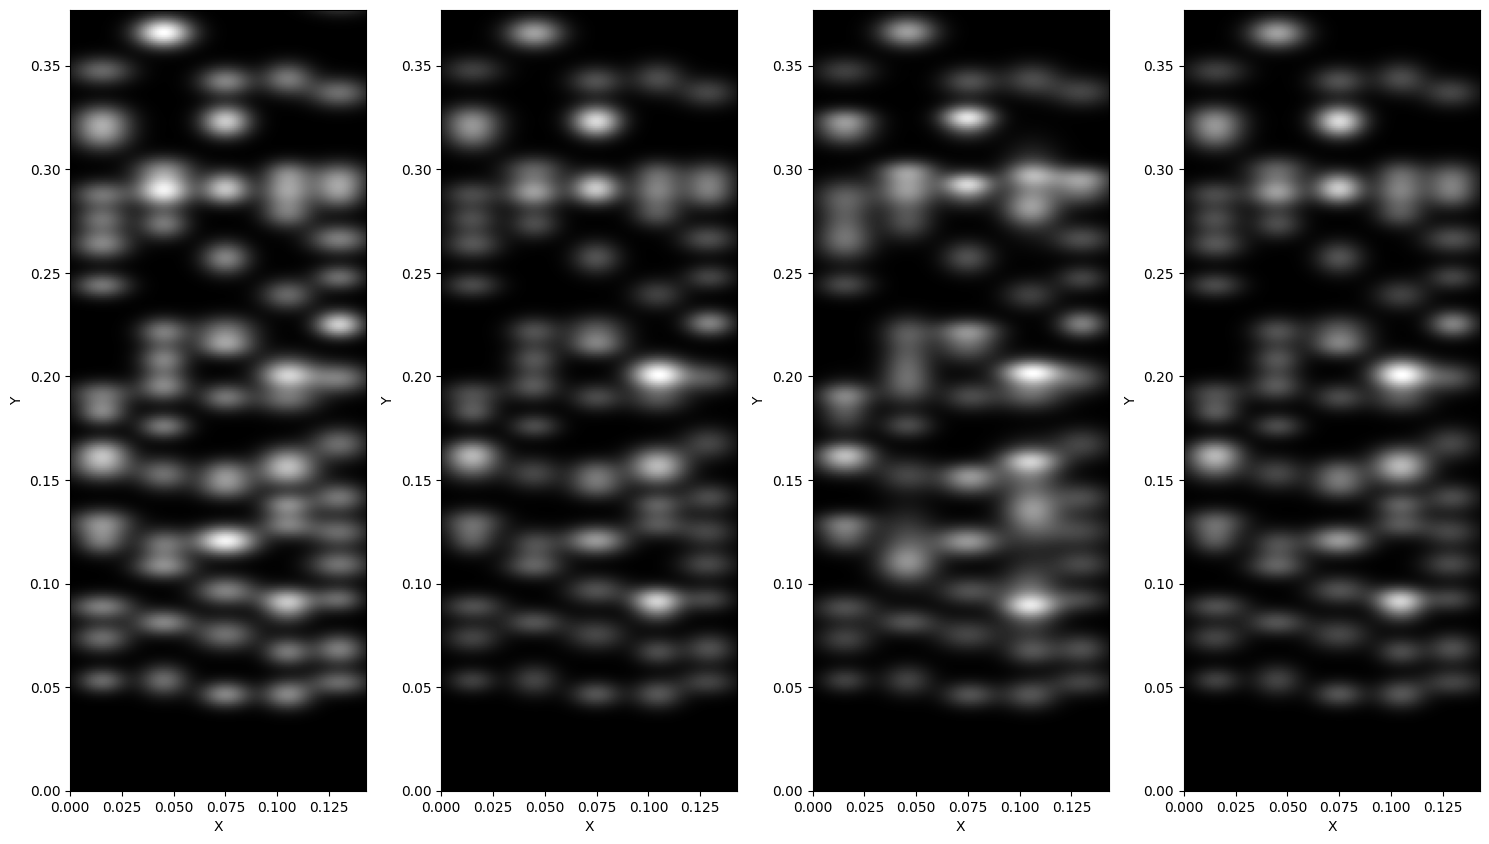

In [ ]:
plt.ion()
plt.tight_layout()
plt.show()